# Прогнозирование оттока клиентов: телекоммуникации

**Цель исследования** — на основе персональных данных о некоторых клиентах, информации об их тарифах и услугах оператора связи «ТелеДом» спрогнозировать, разорвёт ли абонент договор. Для этого необходимо построить модель для прогноза оттока клиентов. Это поможет бороться с оттоком клиентов - сотрудники оператора связи начнут предлагать промокоды и специальные условия всем, кто планирует отказаться от услуг связи.

**Ход исследования**

В связи с тем, что о качестве данных ничего не известно, перед исследованием данных необходимо провести обзор данных. После проверки данных на ошибки, различные артефакты, пропуски найдем возможность исправить самые критичные ошибки данных. Затем уже будем обучать модели на обучающей выборке, вычислять метрики и подбирать гиперпараметры и тестировать лучшую модель на тестовой выборке.
 
Таким образом, исследование пройдёт в пять этапов:
 1. Обзор данных.
 2. Анализ данных.
 3. Подготовка данных.
 4. Построение и обучение моделей.
 5. Тестирование.

**Описание данных:**

**1. contract_new.csv** — информация о договоре

- **Признаки**

`customerID` — идентификатор абонента

`BeginDate` — дата начала действия договора

`EndDate` — дата окончания действия договора

`Type` — тип оплаты: раз в год-два или ежемесячно

`PaperlessBilling` — электронный расчётный лист

`PaymentMethod` — тип платежа

`MonthlyCharges` — расходы за месяц

`TotalCharges` — общие расходы абонента

**2. personal_new.csv** — персональные данные клиента

- **Признаки**

`customerID` — идентификатор пользователя

`gender` — пол

`SeniorCitizen` — является ли абонент пенсионером

`Partner` — есть ли у абонента супруг или супруга

`Dependents` — есть ли у абонента дети

**3. internet_new.csv** — информация об интернет-услугах

- **Признаки**

`customerID` — идентификатор пользователя

`InternetService` — тип подключения: через телефонную линию (DSL) или оптоволоконный кабель (Fiber optic)

`OnlineSecurity` — блокировка опасных сайтов

`OnlineBackup` — облачное хранилище файлов для резервного копирования данных

`DeviceProtection` — антивирус

`TechSupport` — выделенная линия технической поддержки

`StreamingTV` — стриминговое телевидение

`StreamingMovies` — каталог фильмов

**4. phone_new.csv** — информация об услугах телефонии

- **Признаки**

`customerID` — идентификатор пользователя

`MultipleLines` — подключение телефона к нескольким линиям одновременно.

Информация о договорах актуальна на 1 февраля 2020 года.

**Требования**

ROC-AUC должна быть не ниже 0.85.

## Подготовка данных

### Загрузка библиотек

Настроим окружение, импортируем все необходимые библиотеки, устанавливаем размер графиков.

In [1]:
# библиотека для проверки коллинеарности признаков
!pip install phik

In [2]:
# библиотека для перевода названий столбцов в snake_case 
!pip install snakecase

  Created wheel for snakecase: filename=snakecase-1.0.1-py3-none-any.whl size=1982 sha256=06c97057218f97c30d92f71ef5a3a5695cd651379caf15b15c4ceb513038f558
  Stored in directory: /home/jovyan/.cache/pip/wheels/a3/77/52/32741b642306368f1f719076717b5442ae72c918e9035ee926
Successfully built snakecase


In [3]:
!pip install -U scikit-learn

     |████████████████████████████████| 10.9 MB 2.5 MB/s eta 0:00:01
     |████████████████████████████████| 302 kB 62.3 MB/s eta 0:00:01
  Attempting uninstall: joblib
    Found existing installation: joblib 1.1.0
    Uninstalling joblib-1.1.0:
      Successfully uninstalled joblib-1.1.0
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 0.24.1
    Uninstalling scikit-learn-0.24.1:
      Successfully uninstalled scikit-learn-0.24.1


In [4]:
# импорт библиотек
import os
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import statistics
import numpy as np
import phik
import snakecase
from matplotlib import rcParams, rcParamsDefault
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, roc_curve, precision_recall_curve, confusion_matrix, ConfusionMatrixDisplay
from tqdm import tqdm

rcParams['figure.figsize'] = 10,6

In [5]:
pd.options.mode.chained_assignment = None # убираем предупреждение SettingWithCopy

In [6]:
MY_RANDOM_STATE = np.random.seed(251223)

### Функции

Функция, выводящая все необходимые нам характеристики для данных.

In [7]:
def dataframe_information(data):
    '''
    Функция принимает датафрейм для анализа и возвращает датафрейм с основными статистиками данных
    data - датафрейм
    Return:
    df_res - датафрейм с характеристиками данных
    '''
    
    df_data = []
    df_cols = ['name', 'object', 'na', 'zero', 'rate', 'unique', 'neg'
               , 'mean', 'moda', 'std', 'min', 'max', 'out left', 'out rigth', '25%', '50%', '75%']
    
    # перебираем столбцы в наборе данных
    for column_name in data.columns:
               
        # считаем характеристики
        column_type = data[column_name].dtypes
        column_na_values = data[column_name].isna().sum()
        column_zero_values = data[column_name][data[column_name] == 0].count()
        column_na_zero_rate = (column_na_values + column_zero_values) / data.shape[0]
        column_unique_values = data[column_name].nunique()
        column_negative_values = (data[column_name][data[column_name] < 0].count()
                                  if data[column_name].dtypes != 'object' else 0)
        column_mean = data[column_name].mean() if data[column_name].dtypes != 'object' else 0
        column_moda = statistics.mode(data[column_name])
        column_std = data[column_name].std() if data[column_name].dtypes != 'object' else 0
        column_min = data[column_name].min() if data[column_name].dtypes != 'object' else 0
        column_max = data[column_name].max() if data[column_name].dtypes != 'object' else 0
        outliers_left_number = (data[column_name][data[column_name] < data[column_name].quantile(.025)].count()
                                if data[column_name].dtypes != 'object' else 0)
        outliers_right_number = (data[column_name][data[column_name] > data[column_name].quantile(.975)].count()
                                 if data[column_name].dtypes != 'object' else 0)
        percentile_25 = data[column_name].quantile(.25) if data[column_name].dtypes != 'object' else 0
        percentile_50 = data[column_name].quantile(.50) if data[column_name].dtypes != 'object' else 0
        percentile_75 = data[column_name].quantile(.75) if data[column_name].dtypes != 'object' else 0
       
    # собираем показатели по каждому полю
        df_data.append([column_name, column_type, column_na_values
                                 , column_zero_values, column_na_zero_rate, column_unique_values
                                 , column_negative_values, column_mean, column_moda, column_std, column_min
                                 , column_max, outliers_left_number, outliers_right_number
                                 , percentile_25, percentile_50, percentile_75])
    
    # формируем набор данных
    df_res = pd.DataFrame(data = df_data, columns = df_cols)
    
    return df_res

Функция для поиска выбросов.

In [8]:
def search_outliers(data, col, col_name=None, hist_range=None, boxplot_range=None):
    '''
    Функция принимает датафрейм и столбец, ищет выбросы с помощью IQR и строит boxplot
    data - датафрейм
    col - столбец датафрейма
    col_name - наименование столбца (для графика)
    hist_range - интервал для построения гистограммы
    boxplot_range - интервал для изменения масштаба диаграммы размаха
    Return:
    lower_fence - верхняя граница нормальных значений
    upper_fence - нижняя граница нормальных значений
    '''
    # находим 3-й и 1-й квартили
    Q3 = np.quantile(data[col], 0.75, axis=0)
    Q1 = np.quantile(data[col], 0.25, axis=0)
    # находим межквартильный размах
    IQR = Q3 - Q1
    # находим границы нормального размаха
    upper_fence = round(Q3 + 1.5 * IQR, 2)
    lower_fence = round(Q1 - 1.5 * IQR, 2)
    # выводим интервалы фактических значений и нормальных значений, количество аномальных значений
    print('-' * 45)
    print(f'Интервал фактических значений для переменной {col} от {round(data[col].min(),2)} до {round(data[col].max(),2)}')
    print(f'Интервал нормальных значений для переменной {col} от {lower_fence} до {upper_fence}')

    print(f'Переменная {col} содержит аномальных значений : {round(data[(data[col]>upper_fence)| (data[col]<lower_fence)].shape[0]/data.shape[0]*100, 2)}%')

    if data[(data[col] == 0)].shape[0]>0:
        print(f'Переменная {col} содержит нулевые значения {round(data[(data[col] == 0)].shape[0]/data.shape[0]*100, 2)}%')
    
    #  строим распределение признака    
    if col_name != None:
        data.loc[:, [col]].hist(bins=50, edgecolor = 'black', range=(hist_range))
        plt.xlabel(col_name)
        plt.ylabel('Количество наблюдений')
        plt.title(f'Распределение признака {col_name}')
        plt.grid(True)
        plt.show()
            
    #  строим диаграмму размаха    
    if col_name != None:
        data.loc[:, [col]].boxplot().set(title=f'Диаграмма размаха значений переменной {col_name}',
                                         ylabel=col_name) #  строим диаграмму размаха
        plt.ylim(boxplot_range) # изменяем масштаб, чтобы лучше разглядеть "ящик с усами
        plt.show()
    
    return lower_fence, upper_fence

Функция для обучения моделей и подбора гиперпараметров.

In [9]:
def training(model, params, features_train, target_train):
    '''
    Функция принимает пайплайн, гиперпараметры для поиска наилучших, признаки обучающей выборки, 
    целевой признак обучающей выборки, производит подбор наилучших гиперпараметров кросс-валидацией с помощью
    GridSearchCV, обучает модель и возвращает обученную модель
    model - модель
    params - гиперпараметры для поиска наилучших
    features_train - признаки обучающей выборки
    target_train - целевой признак обучающей выборки
    Return:
    grid - обученная модель
    '''
    # создаем экземпляр GridSearchCV
    grid = GridSearchCV(model,
                        param_grid=params,
                        scoring='roc_auc',
                        cv=3,
                        verbose=3)
    # запускаем обучение
    grid.fit(features_train, target_train)
    # выводим на экран наилучшие гиперпараметры и метрику ROC AUC
    print('Лучший результат (ROC AUC):', grid.best_score_)
    print('Лучшие параметры:', grid.best_params_)
    return grid

Функция, которая строит PR-кривую и ROC-кривую.

In [10]:
def ml_threshold(model, data_list):
    '''
    Функция принимает в параметры модель, обучающую выборку, выводит PR-кривую, ROC-кривую.
    model - модель;
    data_list - список, содержащий обучающую выборку [features_test, target_test].
    '''
    predictions = model.predict_proba(data_list[0])# найдем вероятности классов
        
    # построим PR-кривую
    precision, recall, thresholds = precision_recall_curve(
        data_list[1], predictions[:, 1]
    )    
    plt.figure(figsize=(10, 10))
    plt.step(recall, precision, where='post')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title('PR-кривая')
     
    # построим ROC-кривую
    fpr, tpr, thresholds = roc_curve(data_list[1], predictions[:, 1])
    plt.figure(figsize=(10, 10))
    plt.plot(fpr, tpr, linestyle='-')
    plt.plot([0, 1], [0, 1], linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC-кривая')
   
    plt.show()

### Загрузка данных

Считаем данные из csv-файлов `/datasets/contract_new.csv`, `/datasets/personal_new.csv`, `/datasets/internet_new.csv`, `/datasets/phone_new.csv` в датафреймы и сохраним соответственно в переменные `contract`, `personal`, `internet`, `phone`.

In [11]:
# чтение файла с данными и сохранение в переменных
# создаем словарь с названием переменной, куда будем сохранять датафреймы, и с наименованием файла
dataframes = {
    "contract": "contract_new.csv",
    "personal": "personal_new.csv",
    "internet": "internet_new.csv",
    "phone": "phone_new.csv"
}
# перебираем в цикле элементы словаря и сохраняем данные из файлов в переменные с названием из словаря
for dataframe, file in dataframes.items():
    pth1 = '/datasets/'
    pth2 = 'https://code.s3.yandex.net/datasets/'
    if os.path.exists(f'/datasets/{file}'):
        exec("%s = pd.read_csv('/datasets/%s')" % (dataframe,file))
    elif os.path.exists(f'https://code.s3.yandex.net/datasets/{file}'):
        exec("%s = pd.read_csv('https://code.s3.yandex.net/datasets/%s')" % (dataframe,file))
    else:
        print('Something is wrong')

Проверим размерность датасетов.

In [12]:
# посмотрим на размеры датасетов
contract.shape, personal.shape, internet.shape, phone.shape

((7043, 8), (7043, 5), (5517, 8), (6361, 2))

Видим, что в датафреймах `contract` и `personal` количество строк совпадает, а в датафреймах `internet` и `phone` строк меньше, то есть, видимо, информация есть не по всем клиентам.

Выведем первые 10 строчек каждого из датафреймов на экран.

In [13]:
# создадим словарь с наименованием датафрейма и самим датафреймом
dataframes = {
    "contract": contract,
    "personal": personal,
    "internet": internet,
    "phone": phone
}

In [14]:
# перебираем в цикле элементы словаря и выводим первых 10 строк датафреймов
for dataframe, data in dataframes.items():
    print('#' * 14)
    print('##', dataframe, '##')
    print('#' * 14)
    display(data.head(10))

##############
## contract ##
##############


,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84
2,3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.6
4,9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.5
5,9305-CDSKC,2019-03-01,No,Month-to-month,Yes,Electronic check,99.65,1150.96
6,1452-KIOVK,2018-04-01,No,Month-to-month,Yes,Credit card (automatic),89.10,2058.21
7,6713-OKOMC,2019-04-01,No,Month-to-month,No,Mailed check,29.75,300.48
8,7892-POOKP,2017-07-01,No,Month-to-month,Yes,Electronic check,104.80,3573.68
9,6388-TABGU,2014-12-01,2017-05-01,One year,No,Bank transfer (automatic),56.15,1628.35


##############
## personal ##
##############


,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No
5,9305-CDSKC,Female,0,No,No
6,1452-KIOVK,Male,0,No,Yes
7,6713-OKOMC,Female,0,No,No
8,7892-POOKP,Female,0,Yes,No
9,6388-TABGU,Male,0,No,Yes


##############
## internet ##
##############


,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No
5,9305-CDSKC,Fiber optic,No,No,Yes,No,Yes,Yes
6,1452-KIOVK,Fiber optic,No,Yes,No,No,Yes,No
7,6713-OKOMC,DSL,Yes,No,No,No,No,No
8,7892-POOKP,Fiber optic,No,No,Yes,Yes,Yes,Yes
9,6388-TABGU,DSL,Yes,Yes,No,No,No,No


##############
## phone ##
##############


,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes
5,7892-POOKP,Yes
6,6388-TABGU,No
7,9763-GRSKD,No
8,7469-LKBCI,No
9,8091-TTVAX,Yes


Данные успешно загружены в датафреймы. Поле `EndDate` в датафрейме `contract` можно использовать, как целевой признак - клиент разорвал контракт, либо нет.

Все наименования полей следует привести к "змеиному стилю".

**Выводы:** 
- данные успешно загружены в датафреймы `contract`, `personal`, `internet`, `phone` и соответствуют предоставленному описанию;
- количество строк в датафреймах с данными об использовании интернета и телефонии меньше, чем строк в датафреймах с данными о клиентах и контрактах. То есть какие-то клиенты пользуются телефонией и не пользуются интернетом и наоборот, значит, при объединении датафреймов появятся пропуски;
- наименования полей не соответствуют "змеиному стилю".

## Исследовательский анализ и предобработка данных

### Исследование данных

#### Исследование данных о договорах (contract)

Выведем основную информацию о датафрейме.

In [15]:
display(contract.head())
contract.info()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84
2,3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.6
4,9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.5


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


Итак, в таблице 8 столбцов. Пропусков нет. 

Есть категориальные признаки: `Type`, `PaperlessBilling`, `PaymentMethod`.

Признаки `MonthlyCharges` и `TotalCharges` содержат числовые значения. Признак `TotalCharges` имеет тип `object`, его необходимо преобразовать во `float64`. 

Признаки `BeginDate` и `EndDate` содержат информацию о дате начала и окончания действия договора, их необходимо исключить из датафрейма, создав на их основе новые более информативные признаки, не привязанные к определенным датам. Признак `EndDate` будем использовать, как целевой признак - клиент разорвал контракт, либо нет. На основе признака `BeginDate` создадим признак длительность контракта, исходя из того, что информация о договорах актуальна на 1 февраля 2020 года согласно требованиям. Перед изменениями необходимо изменить тип данных в `BeginDate` и `EndDate` на `datetime`.

Названия столбцов не соответствуют общепринятым правилам (змеиному ргистру).

Таким образом, из датафрейма `contract` для обучения модели мы используем следующие признаки: `Type`, `PaperlessBilling`, `PaymentMethod`, `MonthlyCharges`, `TotalCharges`, `duration` (на основе признака `BeginDate`), `exited` — факт ухода клиента (на основе признака `EndDate`).

Посмотрим основные статистичекие метрики.

In [16]:
# выводим статистические метрики
contract.describe().T

,count,mean,std,min,25%,50%,75%,max
MonthlyCharges,7043.0,64.761692,30.090047,18.25,35.5,70.35,89.85,118.75


In [17]:
# вызываем функцию для расчета характеристик по данным
dataframe_information(contract)

,name,object,na,zero,rate,unique,neg,mean,moda,std,min,max,out left,out rigth,25%,50%,75%
0,customerID,object,0,0,0.0,7043,0,0.000000,7590-VHVEG,0.000000,0.00,0.00,0,0,0.0,0.00,0.00
1,BeginDate,object,0,0,0.0,77,0,0.000000,2014-02-01,0.000000,0.00,0.00,0,0,0.0,0.00,0.00
2,EndDate,object,0,0,0.0,67,0,0.000000,No,0.000000,0.00,0.00,0,0,0.0,0.00,0.00
3,Type,object,0,0,0.0,3,0,0.000000,Month-to-month,0.000000,0.00,0.00,0,0,0.0,0.00,0.00
4,PaperlessBilling,object,0,0,0.0,2,0,0.000000,Yes,0.000000,0.00,0.00,0,0,0.0,0.00,0.00
5,PaymentMethod,object,0,0,0.0,4,0,0.000000,Electronic check,0.000000,0.00,0.00,0,0,0.0,0.00,0.00
6,MonthlyCharges,float64,0,0,0.0,1585,0,64.761692,20.05,30.090047,18.25,118.75,149,175,35.5,70.35,89.85
7,TotalCharges,object,0,0,0.0,6658,0,0.000000,,0.000000,0.00,0.00,0,0,0.0,0.00,0.00


Видим, что в поле `Type` есть 3 уникальных значения, в поле `PaperlessBilling` - 2 уникальных значения, что соответствует описанию данных. Так как у признака `TotalCharges` неверный тип данных - мы не видим по нему статистику, но стоит предположить, что значения в этом поле весьма больше, чем в поле `MonthlyCharges`, так как в поле `TotalCharges` общие затраты. То есть существует большой разброс значений и потребуется масштабирование.

Посмотрим распределение категориальных признаков.

In [18]:
for feature in ['Type', 'PaperlessBilling', 'PaymentMethod']:
    print('Значения признака', feature)
    print(contract[feature].value_counts())
    print('_' * 40)
    print()

Значения признака Type
Month-to-month    3875
Two year          1695
One year          1473
Name: Type, dtype: int64
________________________________________

Значения признака PaperlessBilling
Yes    4171
No     2872
Name: PaperlessBilling, dtype: int64
________________________________________

Значения признака PaymentMethod
Electronic check             2365
Mailed check                 1612
Bank transfer (automatic)    1544
Credit card (automatic)      1522
Name: PaymentMethod, dtype: int64
________________________________________



Проверим, есть ли пропуски в данных.

In [19]:
# суммарное количество пропусков в датафрейме contract
contract.isnull().sum()

customerID          0
BeginDate           0
EndDate             0
Type                0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
dtype: int64

Пропусков не наблюдается.

Проверим, нет ли в данных явных дубликатов.

In [20]:
contract.duplicated().sum()

0

Перед измением типа данных в поле `TotalCharges` проверим, не содержит ли это поле нечисловые значения.

In [21]:
# проверка на наличие нечисловых значений в "TotalCharges"
contract[pd.to_numeric(contract["TotalCharges"], errors="coerce").isna()]['TotalCharges'].unique()

array([' '], dtype=object)

Посмотрим на эти строки, чтобы понять причину отсутствия значений в столбце.

In [22]:
contract[pd.to_numeric(contract["TotalCharges"], errors="coerce").isna()]

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
488,4472-LVYGI,2020-02-01,No,Two year,Yes,Bank transfer (automatic),52.55,
753,3115-CZMZD,2020-02-01,No,Two year,No,Mailed check,20.25,
936,5709-LVOEQ,2020-02-01,No,Two year,No,Mailed check,80.85,
1082,4367-NUYAO,2020-02-01,No,Two year,No,Mailed check,25.75,
1340,1371-DWPAZ,2020-02-01,No,Two year,No,Credit card (automatic),56.05,
3331,7644-OMVMY,2020-02-01,No,Two year,No,Mailed check,19.85,
3826,3213-VVOLG,2020-02-01,No,Two year,No,Mailed check,25.35,
4380,2520-SGTTA,2020-02-01,No,Two year,No,Mailed check,20.00,
5218,2923-ARZLG,2020-02-01,No,One year,Yes,Mailed check,19.70,
6670,4075-WKNIU,2020-02-01,No,Two year,No,Mailed check,73.35,


Видим, что во всех этих случаях дата заключения договора -  февраль 2020 года - актуальность данных согласно описанию данных. То есть в столбце `TotalCharges` на месте пробела можно указать данные о расходах за месяц из столбца `MonthlyCharges`.

####  Исследование персональных данных клиентов (personal)

Выведем основную информацию о датафрейме.

In [23]:
display(personal.head())
personal.info()

,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


Итак, в таблице 5 столбцов. Пропусков нет. 

Есть бинарные категориальные признаки: `gender`, `SeniorCitizen`, `Partner`, `Dependents`.

В признаке `SeniorCitizen` есть числовые значения и его тип данных `int64`. Его надо привести к типу `object` и заменить значения 1/0 на Yes/No.

Названия столбцов не соответствуют общепринятым правилам (змеиному ргистру).

Таким образом, из датафрейма `personal` для обучения модели мы используем следующие признаки: `gender`, `SeniorCitizen`, `Partner`, `Dependents`.

Посмотрим распределение категориальных признаков.

In [24]:
for feature in ['gender', 'SeniorCitizen', 'Partner', 'Dependents']:
    print('Значения признака', feature)
    print(personal[feature].value_counts())
    print('_' * 40)
    print()

Значения признака gender
Male      3555
Female    3488
Name: gender, dtype: int64
________________________________________

Значения признака SeniorCitizen
0    5901
1    1142
Name: SeniorCitizen, dtype: int64
________________________________________

Значения признака Partner
No     3641
Yes    3402
Name: Partner, dtype: int64
________________________________________

Значения признака Dependents
No     4933
Yes    2110
Name: Dependents, dtype: int64
________________________________________



Проверим, есть ли пропуски в данных.

In [25]:
# суммарное количество пропусков в датафрейме personal
personal.isnull().sum()

customerID       0
gender           0
SeniorCitizen    0
Partner          0
Dependents       0
dtype: int64

Пропусков не наблюдается.

Проверим, нет ли в данных явных дубликатов.

In [26]:
personal.duplicated().sum()

0

####  Исследование информация об интернет-услугах (internet)

Выведем основную информацию о датафрейме.

In [27]:
display(internet.head())
internet.info()

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


В таблице 8 столбцов. Пропусков нет. 

Есть категориальные признаки: `InternetService`, `OnlineSecurity`, `OnlineBackup`, `DeviceProtection`, `TechSupport`, `StreamingTV`, `StreamingMovies`.

Названия столбцов не соответствуют общепринятым правилам (змеиному ргистру).

Таким образом, из датафрейма `internet` для обучения модели мы используем следующие признаки: `InternetService`, `OnlineSecurity`, `OnlineBackup`, `DeviceProtection`, `TechSupport`, `StreamingTV`, `StreamingMovies`.

Посмотрим распределение категориальных признаков.

In [28]:
for feature in internet.drop(['customerID'], axis=1).columns:
    print('Значения признака', feature)
    print(internet[feature].value_counts())
    print('_' * 40)
    print()

Значения признака InternetService
Fiber optic    3096
DSL            2421
Name: InternetService, dtype: int64
________________________________________

Значения признака OnlineSecurity
No     3498
Yes    2019
Name: OnlineSecurity, dtype: int64
________________________________________

Значения признака OnlineBackup
No     3088
Yes    2429
Name: OnlineBackup, dtype: int64
________________________________________

Значения признака DeviceProtection
No     3095
Yes    2422
Name: DeviceProtection, dtype: int64
________________________________________

Значения признака TechSupport
No     3473
Yes    2044
Name: TechSupport, dtype: int64
________________________________________

Значения признака StreamingTV
No     2810
Yes    2707
Name: StreamingTV, dtype: int64
________________________________________

Значения признака StreamingMovies
No     2785
Yes    2732
Name: StreamingMovies, dtype: int64
________________________________________



Все признаки бинарные категориальные.

Проверим, есть ли пропуски в данных.

In [29]:
# суммарное количество пропусков в датафрейме personal
internet.isnull().sum()

customerID          0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
dtype: int64

Пропусков не наблюдается.

Проверим, нет ли в данных явных дубликатов.

In [30]:
internet.duplicated().sum()

0

#### Исследование информация об услугах телефонии (phone)

Выведем основную информацию о датафрейме.

In [31]:
display(phone.head())
phone.info()

,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


В таблице 2 столбца. Пропусков нет. 

Есть бинарный категориальный признак: `MultipleLines`.

Названия столбцов не соответствуют общепринятым правилам (змеиному ргистру).

Таким образом, из датафрейма `phone` для обучения модели мы используем один признак: `MultipleLines`.

Посмотрим распределение категориального признака.

In [32]:
phone['MultipleLines'].value_counts()

No     3390
Yes    2971
Name: MultipleLines, dtype: int64

Проверим, есть ли пропуски в данных.

In [33]:
# суммарное количество пропусков в датафрейме personal
phone.isnull().sum()

customerID       0
MultipleLines    0
dtype: int64

Пропусков не наблюдается.

Проверим, нет ли в данных явных дубликатов.

In [34]:
phone.duplicated().sum()

0

**Выводы:**
1. В датафрейме с данными о договорах (contract):
- содержится 8 признаков и 7043 объекта;
- нет явных пропусков и дубликатов;
- есть некорректные типы данных: 
    - тип данных в столбце `TotalCharges` необходимо преобразовать из `object` во `float64`;
    - тип данных в столбцах `BeginDate` и `EndDate` необходимо преобразовать из `object` в `datetime`;
- есть неявные пропуски: в столбце `TotalCharges` содержатся пробелы  у клиентов, заключивших договор 01.02.2020 - пропуски необходимо заполнить до преобразования типа данных информацией из столбца `MonthlyCharges`;
- необходимо создать новые признаки на основании сущес твующих с их последующим удалением: признак `EndDate` будем использовать, как целевой признак - клиент разорвал контракт, либо нет (1/0). На основе признака `BeginDate` создадим признак длительность контракта, исходя из того, что информация о договорах актуальна на 1 февраля 2020 года;
- есть категориальные признаки: `Type`, `PaperlessBilling`, `PaymentMethod`, которые необходимо будет кодировать в зависимости от алгоритмов: OneHotEncoder - подойдет для регрессии, OrdinalEncoder - используем для решающих деревьев, для градиентного бустинга воспользуемся встроенным кодировщиком;
- названия признаков не соответсвуют «змеиному стилю».
2. В датафрейме с персональными данными клиентов (personal):
- содержится 5 признаков и 7043 объекта;
- нет явных пропусков и дубликатов;
- есть некорректные типы данных: в категориальном столбце `SeniorCitizen` есть числовые значения и его тип данных `int64`: тип данных надо привести к `object` и заменить значения 1/0 на Yes/No;
- есть категориальные признаки: `gender`, `SeniorCitizen`, `Partner`, `Dependents`, которые необходимо будет кодировать в зависимости от алгоритмов: OneHotEncoder - подойдет для регрессии, OrdinalEncoder - используем для решающих деревьев, для градиентного бустинга воспользуемся встроенным кодировщиком;
- названия признаков не соответсвуют «змеиному стилю».
3. В датафрейме с информацией об интернет-услугах (internet):
- содержится 8 признаков и 5517 объекта;
- нет явных пропусков и дубликатов;
- есть категориальные признаки: `InternetService`, `OnlineSecurity`, `OnlineBackup`, `DeviceProtection`, `TechSupport`, `StreamingTV`, `StreamingMovies`, которые необходимо будет кодировать в зависимости от алгоритмов: OneHotEncoder - подойдет для регрессии, OrdinalEncoder - используем для решающих деревьев, для градиентного бустинга воспользуемся встроенным кодировщиком;
- названия признаков не соответсвуют «змеиному стилю».
4. В датафрейме с информацией об услугах телефонии (phone)¶:
- содержится 2 признака и 6361 объекта;
- нет явных пропусков и дубликатов;
- есть категориальный признак: `MultipleLines`, который необходимо будет кодировать в зависимости от алгоритмов: OneHotEncoder - подойдет для регрессии, OrdinalEncoder - используем для решающих деревьев, для градиентного бустинга воспользуемся встроенным кодировщиком;
- названия признаков не соответсвуют «змеиному стилю».

### Предобработка данных

#### Предобработка данных в датафрейме contract

Приведем наименования столбцов в датафрейме к "змеиному стилю".

In [35]:
contract = contract.rename(columns=lambda column: snakecase.convert(column))
# проверим изменения
contract.columns

Index(['customer_id', 'begin_date', 'end_date', 'type', 'paperless_billing',
       'payment_method', 'monthly_charges', 'total_charges'],
      dtype='object')

Наименования столбцов изменены корректно.

Изменим тип данных в столбце `total_charges` на `float64`. Предварительно, как выяснилось раннее, заменим пробелы в столбце `total_charges` на значения из столбца `monthly_charges`

In [36]:
# обработка признака "TotalCharges"
# заменяем пробелы на значения признака "MonthlyCharges"
contract.loc[contract['total_charges'] == ' ', 'total_charges'] = contract['monthly_charges']
# изменяем тип данных
contract['total_charges'] = contract['total_charges'].astype('float64')

Создадим целевой признак `exited` на основе признака `end_date`: если поле `end_date` содержит значение 'No', то в `exited` запишем '0', в ином случае - '1'.

In [37]:
# создание целевого признака "exited"
contract['exited'] = 1
contract.loc[contract['end_date'] == 'No', 'exited'] = 0

Создадим признак длительность действия контракта - `duration` на основе полей `begin_date` и `end_date`, если в `end_date`, то рассчитываем длительность исходя из актуальности данных из описания данных - 1 февраля 2020 года. Перед рассчетами необходимо изменить тип данных полей `begin_date` и `end_date` на `datetime`.

In [38]:
# изменение типа данных признака "begin_date"
contract['begin_date'] = pd.to_datetime(contract['begin_date'], format='%Y-%m-%d')

# изменение типа данных признака "begin_date"
# заменяем 'No' в поле 'end_date' на дату '2020-02-01'
contract.loc[contract['end_date'] == 'No', 'end_date'] = '2020-02-01'
# меняем тип данных
contract['end_date'] = pd.to_datetime(contract['end_date'], format='%Y-%m-%d')

# создаем признак "duration"
contract['duration'] = (contract['end_date'] - contract['begin_date']).dt.components.days

Теперь можно удалить ненужные нам признаки - `begin_date` и `end_date`.

In [39]:
# удаление признков "begin_date" и "end_date"
contract = contract.drop(['begin_date', 'end_date'], axis=1)

Проверим измененный датафрейм.

In [40]:
contract.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   customer_id        7043 non-null   object 
 1   type               7043 non-null   object 
 2   paperless_billing  7043 non-null   object 
 3   payment_method     7043 non-null   object 
 4   monthly_charges    7043 non-null   float64
 5   total_charges      7043 non-null   float64
 6   exited             7043 non-null   int64  
 7   duration           7043 non-null   int64  
dtypes: float64(2), int64(2), object(4)
memory usage: 440.3+ KB


Изменения прошли корректно - созданы новые признаки, удалены ненужные, тип данных везде корректный.

#### Предобработка данных в датафрейме personal

Приведем наименования столбцов в датафрейме к "змеиному стилю".

In [41]:
personal = personal.rename(columns=lambda column: snakecase.convert(column))
# проверим изменения
personal.columns

Index(['customer_id', 'gender', 'senior_citizen', 'partner', 'dependents'], dtype='object')

Изменим тип данных в поле `senior_citizen` с целочисленного на `object`: заменим значения 0/1 на No/Yes.

In [42]:
# преобразование типа данных в столбце senior_citizen
personal.loc[personal['senior_citizen'] == 0, 'senior_citizen'] = 'No' 
personal.loc[personal['senior_citizen'] == 1, 'senior_citizen'] = 'Yes' 

Проверим внесенные изменения.

In [43]:
display(personal.head())
personal.info()

,customer_id,gender,senior_citizen,partner,dependents
0,7590-VHVEG,Female,No,Yes,No
1,5575-GNVDE,Male,No,No,No
2,3668-QPYBK,Male,No,No,No
3,7795-CFOCW,Male,No,No,No
4,9237-HQITU,Female,No,No,No


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   customer_id     7043 non-null   object
 1   gender          7043 non-null   object
 2   senior_citizen  7043 non-null   object
 3   partner         7043 non-null   object
 4   dependents      7043 non-null   object
dtypes: object(5)
memory usage: 275.2+ KB


Изменения внесены корректно.

#### Предобработка данных в датафрейме internet

Приведем наименования столбцов в датафрейме к "змеиному стилю".

In [44]:
internet = internet.rename(columns=lambda column: snakecase.convert(column))
# проверим изменения
internet.columns

Index(['customer_id', 'internet_service', 'online_security', 'online_backup',
       'device_protection', 'tech_support', 'streaming_tv',
       'streaming_movies'],
      dtype='object')

Наименования столбцов изменены корректно.

#### Предобработка данных в датафрейме phone

Приведем наименования столбцов в датафрейме к "змеиному стилю".

In [45]:
phone = phone.rename(columns=lambda column: snakecase.convert(column))
# проверим изменения
phone.columns

Index(['customer_id', 'multiple_lines'], dtype='object')

Наименования столбцов изменены корректно.

**Выводы:**
1. В датафрейме с данными о договорах (contract):
- пробелы в столбце `TotalCharges` заменены данными из столбца `MonthlyCharges`;
- тип данных в столбце `TotalCharges` преобразован в `float64`;
- созданы новые признаки:
    - `duration` - длительность договора (разница в днях между датой окончания договора `EndDate` (если даты нет, то используем 1 февраля 2020 года) и датой заключения договора `BeginDate`);
    - `existed` - ушел ли клиент или нет - целевой признак (если в поле `EndDate` была дата, то 1, если в поле не было даты - 0);
- признаки `EndDate` и `BeginDate` удалены;
- названия признаков приведены к «змеиному стилю».
2. В датафрейме с персональными данными клиентов (personal):
- в столбце `SeniorCitizen` значения 1/0 заменены на Yes/No, тип данных стал - `object`;
- названия признаков приведены к «змеиному стилю».
3. В датафрейме с информацией об интернет-услугах (internet):
- названия признаков приведены к «змеиному стилю».
4. В датафрейме с информацией об услугах телефонии (phone)¶:
- названия признаков приведены к «змеиному стилю».

## Объединение данных

В каждом из датафреймов есть признак `customer_id` (идентификатор клиента) - по нему можно объединить данные.

Посмотрим еще раз на размерность датафреймов.

In [46]:
# перебираем в цикле элементы словаря и выводим размерность датафреймов
for dataframe, data in dataframes.items():
    print('#' * 14)
    print('##', dataframe, '##')
    print('#' * 14)
    display(data.shape)

##############
## contract ##
##############


(7043, 8)

##############
## personal ##
##############


(7043, 5)

##############
## internet ##
##############


(5517, 8)

##############
## phone ##
##############


(6361, 2)

В датафреймах `contract` и `personal` одинаковое количество строк, в датафреймах `internet`, `phone` строк меньше, - будем использовать объединение `left`.

In [47]:
# объединяем 4 датафрейма в один по столбцу customer_id, тип объединения - left
data_full = contract \
    .merge(personal, how='left', on='customer_id') \
    .merge(internet, how='left', on='customer_id') \
    .merge(phone, how='left', on='customer_id') 

In [48]:
data_full.shape

(7043, 20)

Удалим ненужный теперь столбец `customer_id`, так как он не обладает никакой информативностью.

In [49]:
# удаляем столбец customer_id
data_full = data_full.drop(['customer_id'], axis=1)

Проверим получившуюся таблицу.

In [50]:
display(data_full.head())
data_full.info()

,type,paperless_billing,payment_method,monthly_charges,total_charges,exited,duration,gender,senior_citizen,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines
0,Month-to-month,Yes,Electronic check,29.85,31.04,0,31,Female,No,Yes,No,DSL,No,Yes,No,No,No,No,NaN
1,One year,No,Mailed check,56.95,2071.84,0,1036,Male,No,No,No,DSL,Yes,No,Yes,No,No,No,No
2,Month-to-month,Yes,Mailed check,53.85,226.17,0,123,Male,No,No,No,DSL,Yes,Yes,No,No,No,No,No
3,One year,No,Bank transfer (automatic),42.30,1960.60,0,1371,Male,No,No,No,DSL,Yes,No,Yes,Yes,No,No,NaN
4,Month-to-month,Yes,Electronic check,70.70,353.50,0,153,Female,No,No,No,Fiber optic,No,No,No,No,No,No,No


<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 19 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   type               7043 non-null   object 
 1   paperless_billing  7043 non-null   object 
 2   payment_method     7043 non-null   object 
 3   monthly_charges    7043 non-null   float64
 4   total_charges      7043 non-null   float64
 5   exited             7043 non-null   int64  
 6   duration           7043 non-null   int64  
 7   gender             7043 non-null   object 
 8   senior_citizen     7043 non-null   object 
 9   partner            7043 non-null   object 
 10  dependents         7043 non-null   object 
 11  internet_service   5517 non-null   object 
 12  online_security    5517 non-null   object 
 13  online_backup      5517 non-null   object 
 14  device_protection  5517 non-null   object 
 15  tech_support       5517 non-null   object 
 16  streaming_tv       5517 

Видим, что в датафрейме теперь имеются пропуски, которые необходимо будет заполнить.

**Выводы:**
1. Датафреймы `contract`, `personal`, `internet` и `phone` объеденены в один датафрейм `data_full` по признаку `customer_id` (идентификатор клиента).
2. Результирующий датафрейм содержит 19 признаков и 7043 объекта.
3. Ввиду того, что в датафреймах `internet`, `phone` есть информация не по всем клиентам, в объединенном датафрейме появились пропуски в столбцах `internet_service`, `online_security`, `online_backup`, `device_protection`, `tech_support`, `streaming_tv`, `streaming_movies`, `multiple_lines`. Их необходимо будет заполнить.

## Исследовательский анализ и предобработка данных объединённого датафрейма

Выведем первые 10 строк датафрейма.

In [51]:
# выводим первые 10 строк
data_full.head(10)

,type,paperless_billing,payment_method,monthly_charges,total_charges,exited,duration,gender,senior_citizen,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines
0,Month-to-month,Yes,Electronic check,29.85,31.04,0,31,Female,No,Yes,No,DSL,No,Yes,No,No,No,No,NaN
1,One year,No,Mailed check,56.95,2071.84,0,1036,Male,No,No,No,DSL,Yes,No,Yes,No,No,No,No
2,Month-to-month,Yes,Mailed check,53.85,226.17,0,123,Male,No,No,No,DSL,Yes,Yes,No,No,No,No,No
3,One year,No,Bank transfer (automatic),42.30,1960.60,0,1371,Male,No,No,No,DSL,Yes,No,Yes,Yes,No,No,NaN
4,Month-to-month,Yes,Electronic check,70.70,353.50,0,153,Female,No,No,No,Fiber optic,No,No,No,No,No,No,No
5,Month-to-month,Yes,Electronic check,99.65,1150.96,0,337,Female,No,No,No,Fiber optic,No,No,Yes,No,Yes,Yes,Yes
6,Month-to-month,Yes,Credit card (automatic),89.10,2058.21,0,671,Male,No,No,Yes,Fiber optic,No,Yes,No,No,Yes,No,Yes
7,Month-to-month,No,Mailed check,29.75,300.48,0,306,Female,No,No,No,DSL,Yes,No,No,No,No,No,NaN
8,Month-to-month,Yes,Electronic check,104.80,3573.68,0,945,Female,No,Yes,No,Fiber optic,No,No,Yes,Yes,Yes,Yes,Yes
9,One year,No,Bank transfer (automatic),56.15,1628.35,1,882,Male,No,No,Yes,DSL,Yes,Yes,No,No,No,No,No


Видим, что присутствуют пропуски.

Выведем основную информацию о датафрейме.

In [52]:
# выведем информацию о датафрейме
data_full.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 19 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   type               7043 non-null   object 
 1   paperless_billing  7043 non-null   object 
 2   payment_method     7043 non-null   object 
 3   monthly_charges    7043 non-null   float64
 4   total_charges      7043 non-null   float64
 5   exited             7043 non-null   int64  
 6   duration           7043 non-null   int64  
 7   gender             7043 non-null   object 
 8   senior_citizen     7043 non-null   object 
 9   partner            7043 non-null   object 
 10  dependents         7043 non-null   object 
 11  internet_service   5517 non-null   object 
 12  online_security    5517 non-null   object 
 13  online_backup      5517 non-null   object 
 14  device_protection  5517 non-null   object 
 15  tech_support       5517 non-null   object 
 16  streaming_tv       5517 

В датафрейме 19 столбцов. Есть пропуски в столбцах `internet_service`, `online_security`, `online_backup`, `device_protection`, `tech_support`, `streaming_tv`, `streaming_movies`, `multiple_lines`. Типы данных корректные.

Посмотрим основные статистичекие метрики.

In [53]:
# выводим статистические метрики
data_full.describe().T

,count,mean,std,min,25%,50%,75%,max
monthly_charges,7043.0,64.761692,30.090047,18.25,35.50,70.35,89.85,118.75
total_charges,7043.0,2115.377573,2112.678861,19.05,436.75,1343.35,3236.69,9221.38
exited,7043.0,0.156325,0.363189,0.00,0.00,0.00,0.00,1.00
duration,7043.0,898.555729,683.130510,0.00,276.00,761.00,1461.00,2314.00


Видим, что есть значительный разброс значений. Следовательно, потребуется масштабирование.

Выведем характеристики данных.

In [54]:
# вызываем функцию для расчета характеристик по данным
dataframe_information(data_full)

,name,object,na,zero,rate,unique,neg,mean,moda,std,min,max,out left,out rigth,25%,50%,75%
0,type,object,0,0,0.000000,3,0,0.000000,Month-to-month,0.000000,0.00,0.00,0,0,0.00,0.00,0.00
1,paperless_billing,object,0,0,0.000000,2,0,0.000000,Yes,0.000000,0.00,0.00,0,0,0.00,0.00,0.00
2,payment_method,object,0,0,0.000000,4,0,0.000000,Electronic check,0.000000,0.00,0.00,0,0,0.00,0.00,0.00
3,monthly_charges,float64,0,0,0.000000,1585,0,64.761692,20.05,30.090047,18.25,118.75,149,175,35.50,70.35,89.85
4,total_charges,float64,0,0,0.000000,6664,0,2115.377573,20.45,2112.678861,19.05,9221.38,177,177,436.75,1343.35,3236.69
5,exited,int64,0,5942,0.843675,2,0,0.156325,0,0.363189,0.00,1.00,0,0,0.00,0.00,0.00
6,duration,int64,0,11,0.001562,251,0,898.555729,2191,683.130510,0.00,2314.00,13,6,276.00,761.00,1461.00
7,gender,object,0,0,0.000000,2,0,0.000000,Male,0.000000,0.00,0.00,0,0,0.00,0.00,0.00
8,senior_citizen,object,0,0,0.000000,2,0,0.000000,No,0.000000,0.00,0.00,0,0,0.00,0.00,0.00
9,partner,object,0,0,0.000000,2,0,0.000000,No,0.000000,0.00,0.00,0,0,0.00,0.00,0.00


Видим, что в столбцах `internet_service`, `online_security`, `online_backup`, `device_protection`, `tech_support`, `streaming_tv`, `streaming_movies` по 1526 пропусков - это 21% всех данных. В столбце `multiple_lines` 682 пропуска - 9%. В столбце `duration` есть 11 нулевых значений - те клиенты, которые заключили договор 1 февраля 2020 года. Отрицательных значений нет. Наблюдаются выбросы в данных.

Отделим числовые и категориальные признаки. 

In [55]:
# отделяем числовые признаки
numeric_features = ['monthly_charges','total_charges', 'duration']
numeric_features

['monthly_charges', 'total_charges', 'duration']

In [56]:
# отделяем категориальные признаки
categorical_features = [col for col in data_full.columns if (col not in numeric_features 
                                                            and col != 'exited')] 
categorical_features

['type',
 'paperless_billing',
 'payment_method',
 'gender',
 'senior_citizen',
 'partner',
 'dependents',
 'internet_service',
 'online_security',
 'online_backup',
 'device_protection',
 'tech_support',
 'streaming_tv',
 'streaming_movies',
 'multiple_lines']

Создадим словарь с наименованиями признаков.

In [57]:
# создадим словарь с наименованиями признаков
features_name = {
    'gender': 'Пол',
    'senior_citizen': 'Является ли абонент пенсионером',
    'partner': 'Есть ли у абонента супруг или супруга',
    'dependents': 'Есть ли у абонента дети',
    'type': 'Тип оплаты',
    'paperless_billing': 'Электронный расчётный лист',
    'payment_method': 'Тип платежа',
    'internet_service': 'Тип подключения',
    'online_security': 'Блокировка опасных сайтов',
    'online_backup': 'Облачное хранилище файлов для резервного копирования данных',
    'device_protection': 'Антивирус',
    'tech_support': 'Выделенная линия технической поддержки',
    'streaming_tv': 'Стриминговое телевидение',
    'streaming_movies': 'Каталог фильмов',
    'multiple_lines': 'Подключение телефона к нескольким линиям одновременно',
    'monthly_charges': 'Расходы за месяц',
    'total_charges': 'Общие расходы абонента',
    'duration': 'Длительность действия договора'
}

Посмотрим количество пропусков в процентах.

In [58]:
# количество пропусков в процентах
pd.DataFrame(round(data_full.isna().mean()*100,)).style.background_gradient('coolwarm')

,0
type,0.000000
paperless_billing,0.000000
payment_method,0.000000
monthly_charges,0.000000
total_charges,0.000000
exited,0.000000
duration,0.000000
gender,0.000000
senior_citizen,0.000000
partner,0.000000


Пропуски есть в 8 столбцах - в процентном соотношении пропусков весьма много, удалять их нельзя - можно потерять слишком много данных. Введем новую категорию - "No_value". Для наглядности построим тепловую карту пропущенных значений.

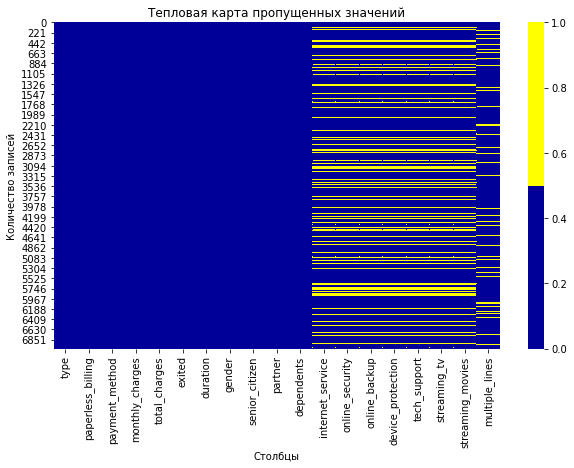

In [59]:
colours = ['#000099', '#ffff00'] 
sns.heatmap(data_full.isnull(), cmap=sns.color_palette(colours))
# указываем наименования осей и графика
plt.xlabel('Столбцы')
plt.ylabel('Количество записей')
plt.title('Тепловая карта пропущенных значений')
plt.show()

Заполним пропуски значением "No_value".

In [60]:
# заполняем пропуски значением No_value
data_full = data_full.fillna('No_value')

Проверим заполнение пропусков.

In [61]:
# суммарное количество пропусков в датафрейме features
data_full.isnull().sum()

type                 0
paperless_billing    0
payment_method       0
monthly_charges      0
total_charges        0
exited               0
duration             0
gender               0
senior_citizen       0
partner              0
dependents           0
internet_service     0
online_security      0
online_backup        0
device_protection    0
tech_support         0
streaming_tv         0
streaming_movies     0
multiple_lines       0
dtype: int64

Пропуски заполнены.

Проверим, нет ли дубликатов в категориальных полях из-за разного регистра.

In [62]:
for feature in categorical_features:
    print('Наличие дубликатов в признаке', feature)
    #посчитаем количество уникальных значений в столбце
    print('Количество уникальных значений:', data_full[feature].nunique())
    #посчитаем количество уникальных значений в столбце, приведенном к верхнему регистру
    print('Количество уникальных значений (в верхнем регистре):', data_full[feature].str.upper().nunique())
    print('_' * 40)
    print()

Наличие дубликатов в признаке type
Количество уникальных значений: 3
Количество уникальных значений (в верхнем регистре): 3
________________________________________

Наличие дубликатов в признаке paperless_billing
Количество уникальных значений: 2
Количество уникальных значений (в верхнем регистре): 2
________________________________________

Наличие дубликатов в признаке payment_method
Количество уникальных значений: 4
Количество уникальных значений (в верхнем регистре): 4
________________________________________

Наличие дубликатов в признаке gender
Количество уникальных значений: 2
Количество уникальных значений (в верхнем регистре): 2
________________________________________

Наличие дубликатов в признаке senior_citizen
Количество уникальных значений: 2
Количество уникальных значений (в верхнем регистре): 2
________________________________________

Наличие дубликатов в признаке partner
Количество уникальных значений: 2
Количество уникальных значений (в верхнем регистре): 2
________

Дубликатов в категориальных полях нет.

Посмотрим распределение целевого признака, проверим баланс классов.

In [63]:
# распределение целевого признака
data_full['exited'].value_counts(normalize=True)

0    0.843675
1    0.156325
Name: exited, dtype: float64

Построим график.

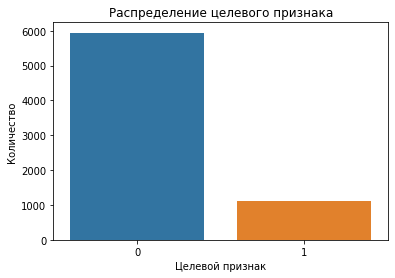

In [64]:
# Bar plot для целевого признака
plt.figure(figsize=(6, 4))
sns.countplot(x=data_full['exited'])
plt.xlabel('Целевой признак')
plt.ylabel('Количество')
plt.title('Распределение целевого признака')
plt.show()

Наблюдается дисбаланс класса - положительного класса всего 16%. Несмотря на наличие дисбаланса кассов, балансировку данных проводить не будем, так как используемая нами метрика ROC-AUC нечувствительна к дисбалансу классов.

Посмотрим наличие выбросов в числовых признаках и построим их распределение.

#####################
## monthly_charges ##
#####################
---------------------------------------------
Интервал фактических значений для переменной monthly_charges от 18.25 до 118.75
Интервал нормальных значений для переменной monthly_charges от -46.02 до 171.38
Переменная monthly_charges содержит аномальных значений : 0.0%


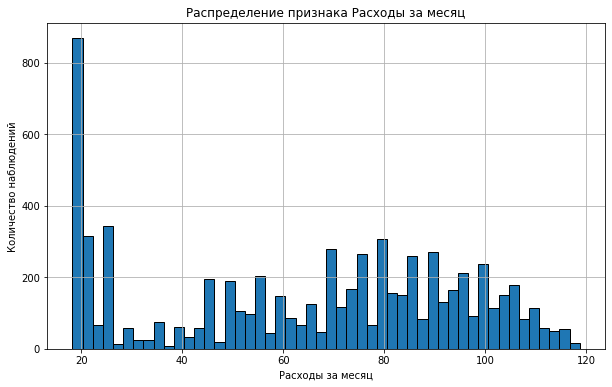

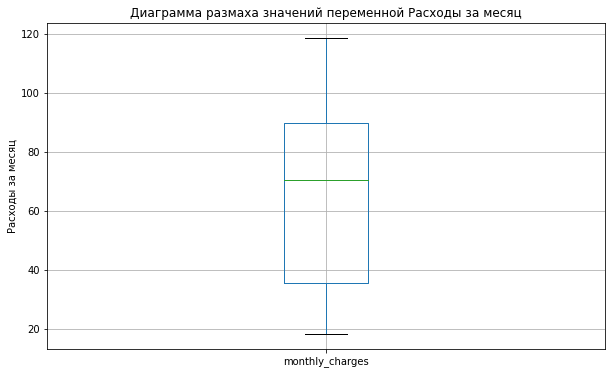


#####################
## total_charges ##
#####################
---------------------------------------------
Интервал фактических значений для переменной total_charges от 19.05 до 9221.38
Интервал нормальных значений для переменной total_charges от -3763.16 до 7436.6
Переменная total_charges содержит аномальных значений : 2.77%


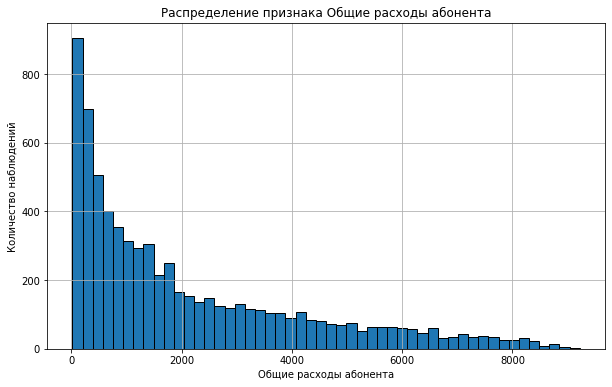

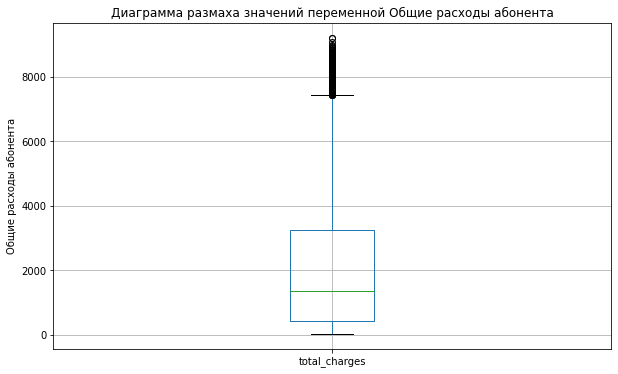


#####################
## duration ##
#####################
---------------------------------------------
Интервал фактических значений для переменной duration от 0 до 2314
Интервал нормальных значений для переменной duration от -1501.5 до 3238.5
Переменная duration содержит аномальных значений : 0.0%
Переменная duration содержит нулевые значения 0.16%


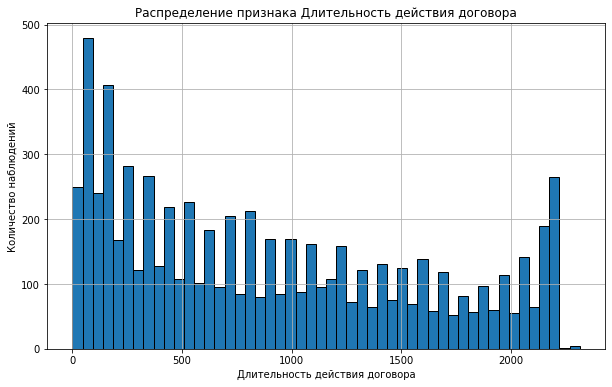

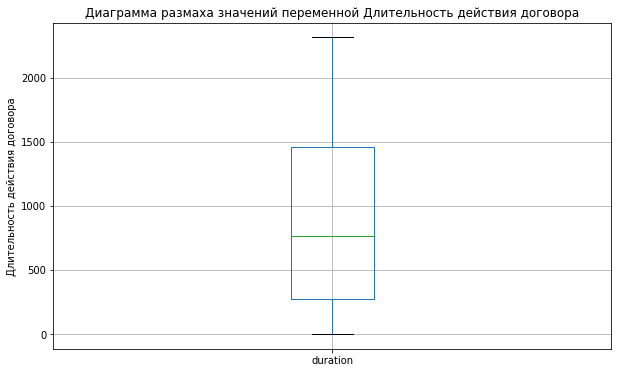

In [65]:
# перебираем в цикле элементы словаря и вызываем функцию для поиска выбросов в каждом из числовых признаков
for feature, feature_name in features_name.items():
    if feature in numeric_features:
        print('#' * 21)
        print('##', feature, '##')
        print('#' * 21)    
        search_outliers(data_full, feature, feature_name)
        print()

Видим, что количественные признаки не имеют нормального распределения, в столбце `total_charges` есть выбросы. 

В столбце `monthly_charges` бимодальное распределение - первый самый большой пик около минимальных значений (около 20), второй пик около 80. 

Значения же в столбце`total_charges` убывают (несмотря на пик около80 в столбце `monthly_charges`), что может свидетельствовать о том, что клиенты, платящие больше ежемесячно, быстрее уходят.

В столбце `duration` так же 2 пика - новые клиенты или клиенты, которые надолго не задержались (около 100 дней), и лояльные клиенты, которые долго пользуются услугами оператора связи (около 2250 дней).

Теперь посмотрим распределение категориальных признаков.

#####################
## gender ##
#####################
Male      0.504756
Female    0.495244
Name: gender, dtype: float64



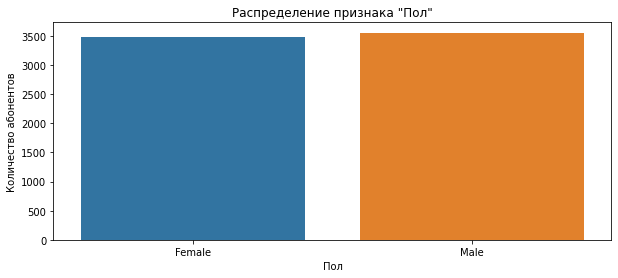

#####################
## senior_citizen ##
#####################
No     0.837853
Yes    0.162147
Name: senior_citizen, dtype: float64



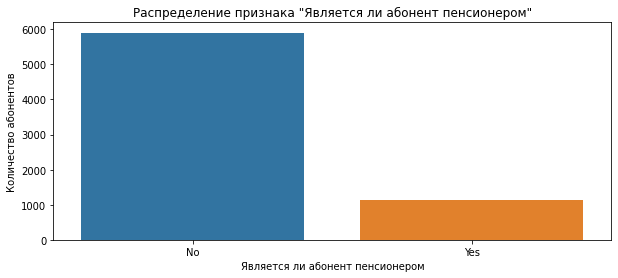

#####################
## partner ##
#####################
No     0.516967
Yes    0.483033
Name: partner, dtype: float64



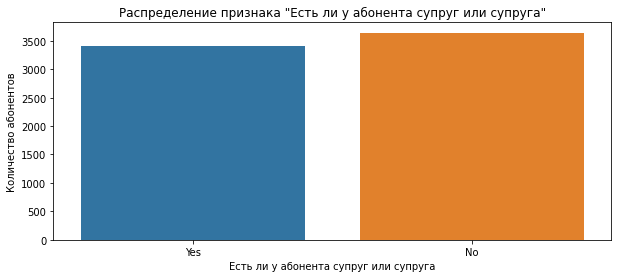

#####################
## dependents ##
#####################
No     0.700412
Yes    0.299588
Name: dependents, dtype: float64



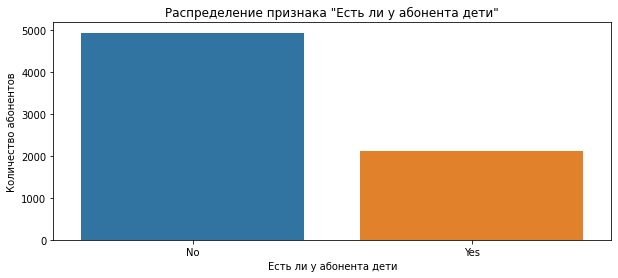

#####################
## type ##
#####################
Month-to-month    0.550192
Two year          0.240664
One year          0.209144
Name: type, dtype: float64



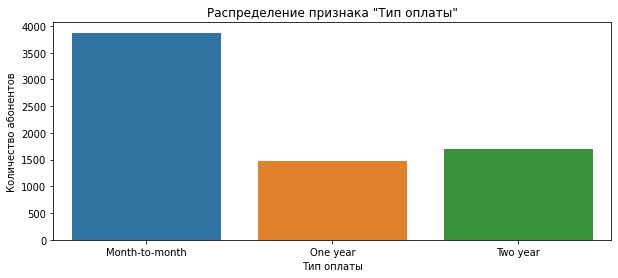

#####################
## paperless_billing ##
#####################
Yes    0.592219
No     0.407781
Name: paperless_billing, dtype: float64



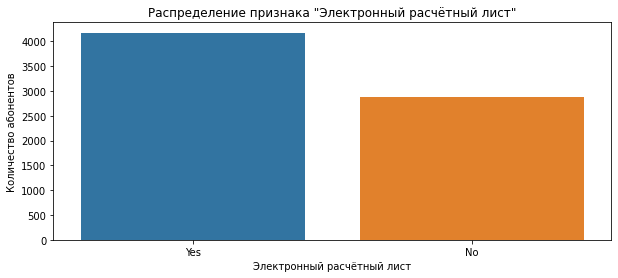

#####################
## payment_method ##
#####################
Electronic check             0.335794
Mailed check                 0.228880
Bank transfer (automatic)    0.219225
Credit card (automatic)      0.216101
Name: payment_method, dtype: float64



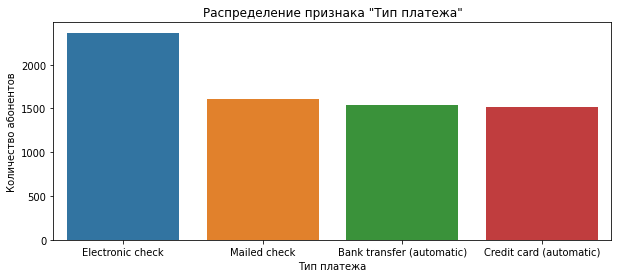

#####################
## internet_service ##
#####################
Fiber optic    0.439585
DSL            0.343746
No_value       0.216669
Name: internet_service, dtype: float64



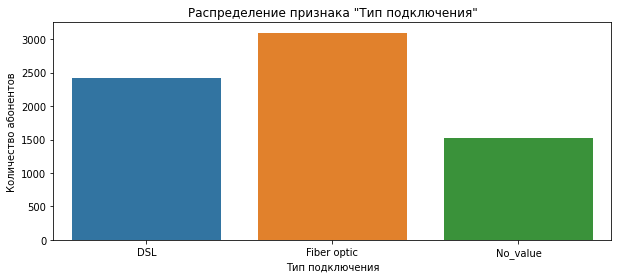

#####################
## online_security ##
#####################
No          0.496663
Yes         0.286668
No_value    0.216669
Name: online_security, dtype: float64



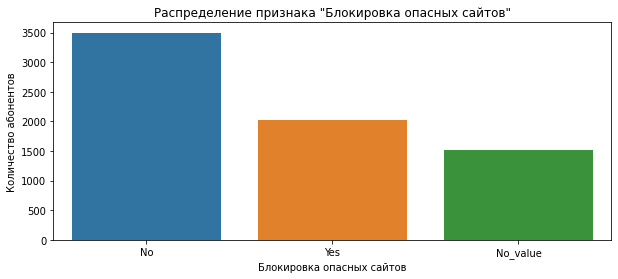

#####################
## online_backup ##
#####################
No          0.438450
Yes         0.344881
No_value    0.216669
Name: online_backup, dtype: float64



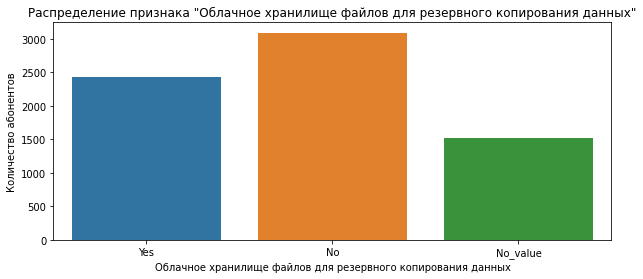

#####################
## device_protection ##
#####################
No          0.439443
Yes         0.343888
No_value    0.216669
Name: device_protection, dtype: float64



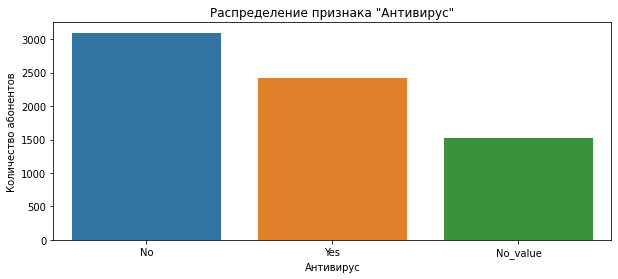

#####################
## tech_support ##
#####################
No          0.493114
Yes         0.290217
No_value    0.216669
Name: tech_support, dtype: float64



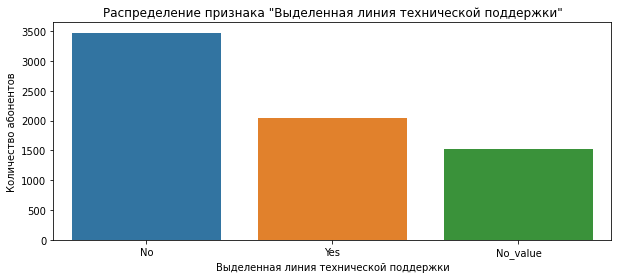

#####################
## streaming_tv ##
#####################
No          0.398978
Yes         0.384353
No_value    0.216669
Name: streaming_tv, dtype: float64



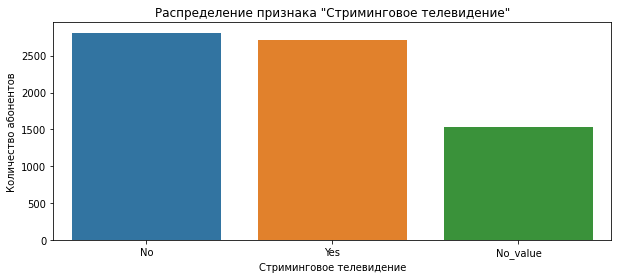

#####################
## streaming_movies ##
#####################
No          0.395428
Yes         0.387903
No_value    0.216669
Name: streaming_movies, dtype: float64



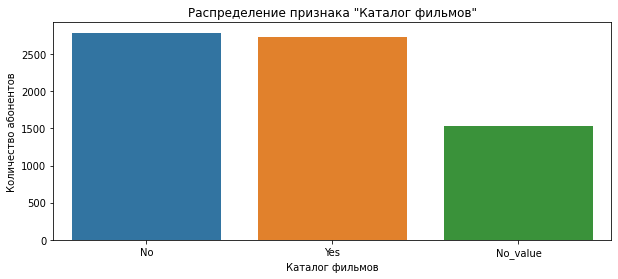

#####################
## multiple_lines ##
#####################
No          0.481329
Yes         0.421837
No_value    0.096834
Name: multiple_lines, dtype: float64



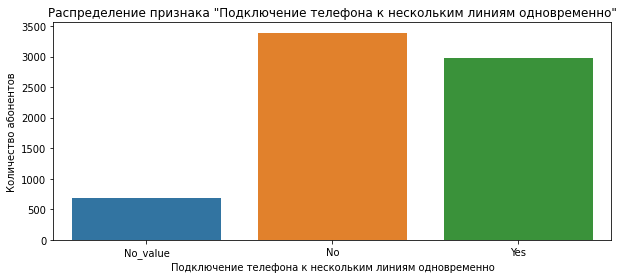

In [66]:
# перебираем в цикле элементы словаря и смотрим распределение категориальых признаков, строим bsr plot
for feature, feature_name in features_name.items():
    if feature in categorical_features:
        print('#' * 21)
        print('##', feature, '##')
        print('#' * 21)    
        print(data_full[feature].value_counts(normalize=True))
        print()
        # Bar plot для признаков
        plt.figure(figsize=(10, 4))
        sns.countplot(x=pd.Series(data_full[feature]))
        plt.xlabel(feature_name)
        plt.ylabel('Количество абонентов')
        plt.title(f'Распределение признака "{feature_name}"')
        plt.show()

В некоторых признаках наблюдается дисбаланс: например, в данных мало пенсионеров (`senior_citizen`) - 16%, абоненты с детьми (`dependents`)  составляют 30%, блокировку опасных сайтов (`online_security`) используют только 29% абонентов, облачное хранилище (`online_backup`) и антивирус (`device_protection`) используют gj 34% абонентов, выделенной линией технической поддержки (`tech_support`) пользуются 29% абонентов, стриминговым телевидением (`streaming_tv`) и каталогом фильмов (`streaming_movies`) пользуются по 39% абонентов. Таким образом, дополнительные услуги у абонентов не пользуются спросом.

Самый популярный тип оплаты (`type`) - помесячный. Люди чаще предпочитают получать счета в электронном виде (`paperless_billing`) и оплачивать их при помощи электронного чека (`payment_method`). Самый частый способ подключения (`internet_service`) - оптоволокно.

Посмотрим на распределение категорильных признаков относительно целевого признака `exited`.

#####################
## gender ##
#####################


,Male,Female
Класс 0 (активные абоненты),0.501851,0.498149
Класс 1 (ушедшие абоненты),0.520436,0.479564


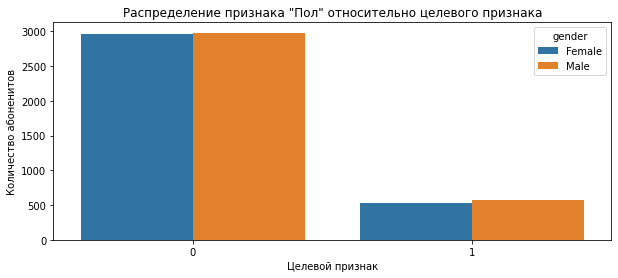

#####################
## senior_citizen ##
#####################


,No,Yes
Класс 0 (активные абоненты),0.846853,0.153147
Класс 1 (ушедшие абоненты),0.789282,0.210718


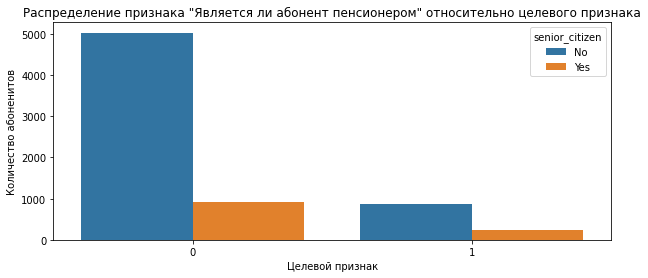

#####################
## partner ##
#####################


,No,Yes
Класс 0 (активные абоненты),0.548469,0.451531
Класс 1 (ушедшие абоненты),0.346957,0.653043


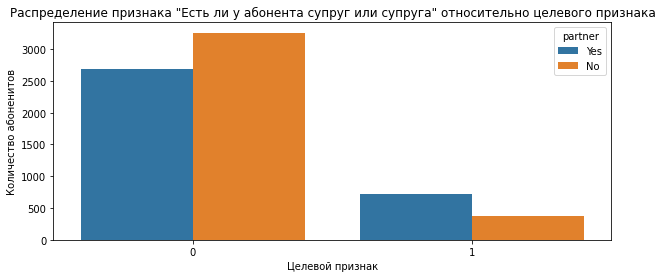

#####################
## dependents ##
#####################


,No,Yes
Класс 0 (активные абоненты),0.706833,0.293167
Класс 1 (ушедшие абоненты),0.665758,0.334242


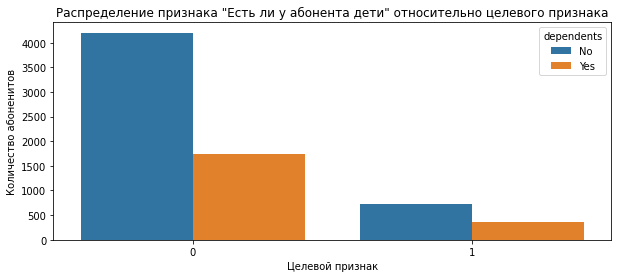

#####################
## type ##
#####################


,Month-to-month,Two year,One year
Класс 0 (активные абоненты),0.583642,0.221138,0.195220
Класс 1 (ушедшие абоненты),0.369664,0.346049,0.284287


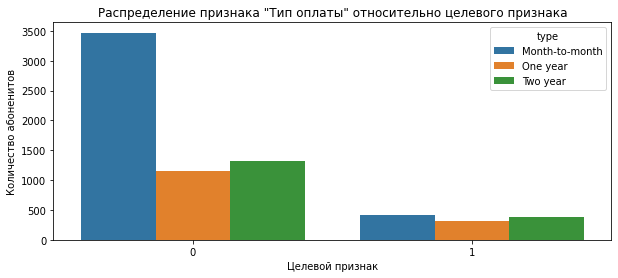

#####################
## paperless_billing ##
#####################


,Yes,No
Класс 0 (активные абоненты),0.580613,0.419387
Класс 1 (ушедшие абоненты),0.654859,0.345141


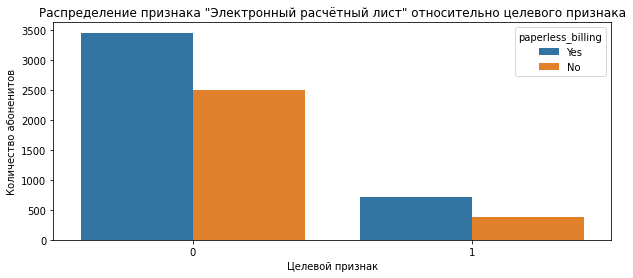

#####################
## payment_method ##
#####################


,Electronic check,Mailed check,Bank transfer (automatic),Credit card (automatic)
Класс 0 (активные абоненты),0.339111,0.251599,0.206496,0.202794
Класс 1 (ушедшие абоненты),0.317893,0.106267,0.287920,0.287920


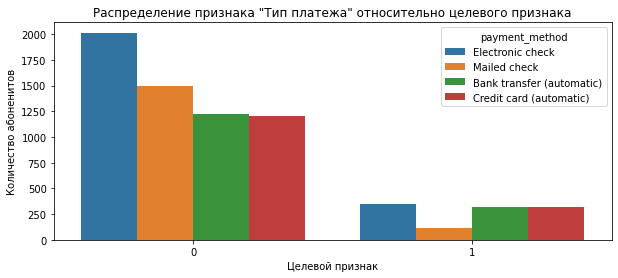

#####################
## internet_service ##
#####################


,Fiber optic,DSL,No_value
Класс 0 (активные абоненты),0.420902,0.349209,0.229889
Класс 1 (ушедшие абоненты),0.540418,0.314260,0.145322


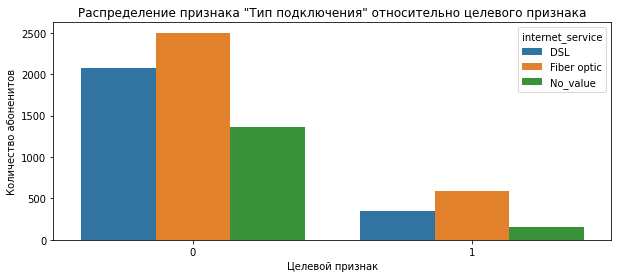

#####################
## online_security ##
#####################


,No,Yes,No_value
Класс 0 (активные абоненты),0.500168,0.269943,0.229889
Класс 1 (ушедшие абоненты),0.477748,0.376930,0.145322


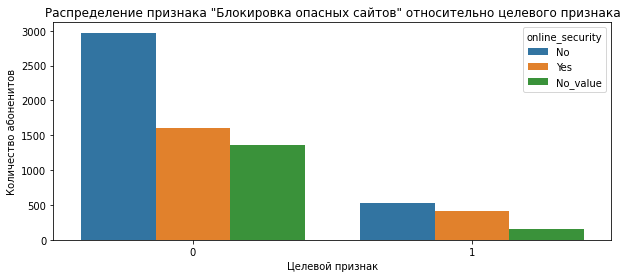

#####################
## online_backup ##
#####################


,No,Yes,No_value
Класс 0 (активные абоненты),0.455571,0.314541,0.229889
Класс 1 (ушедшие абоненты),0.346049,0.508629,0.145322


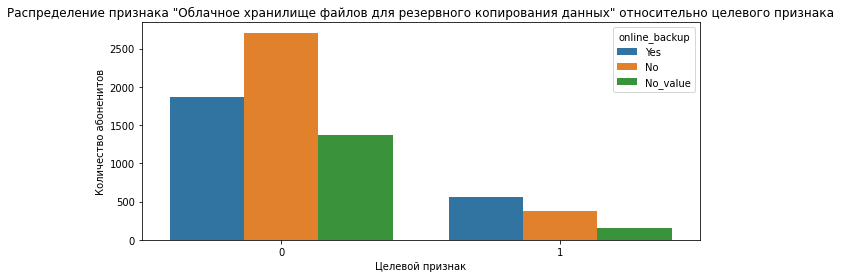

#####################
## device_protection ##
#####################


,No,Yes,No_value
Класс 0 (активные абоненты),0.455066,0.315045,0.229889
Класс 1 (ушедшие абоненты),0.355132,0.499546,0.145322


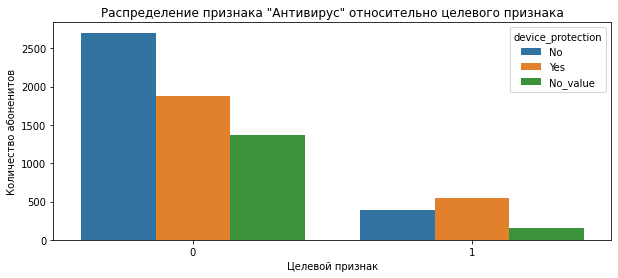

#####################
## tech_support ##
#####################


,No,Yes,No_value
Класс 0 (активные абоненты),0.493100,0.277011,0.229889
Класс 1 (ушедшие абоненты),0.493188,0.361490,0.145322


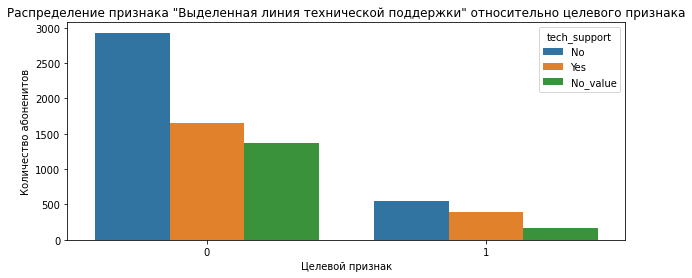

#####################
## streaming_tv ##
#####################


,No,Yes,No_value
Класс 0 (активные абоненты),0.412824,0.357287,0.229889
Класс 1 (ушедшие абоненты),0.324251,0.530427,0.145322


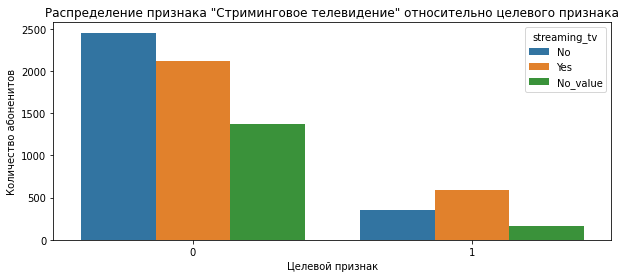

#####################
## streaming_movies ##
#####################


,No,Yes,No_value
Класс 0 (активные абоненты),0.412319,0.357792,0.229889
Класс 1 (ушедшие абоненты),0.304269,0.550409,0.145322


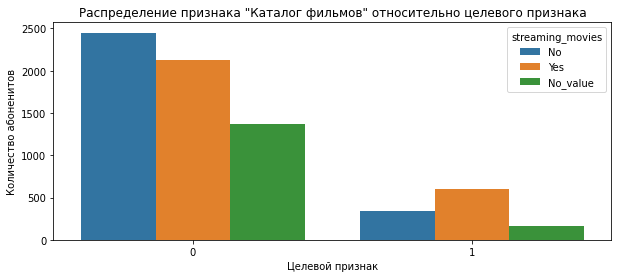

#####################
## multiple_lines ##
#####################


,No,Yes,No_value
Класс 0 (активные абоненты),0.516661,0.385897,0.097442
Класс 1 (ушедшие абоненты),0.290645,0.615804,0.093551


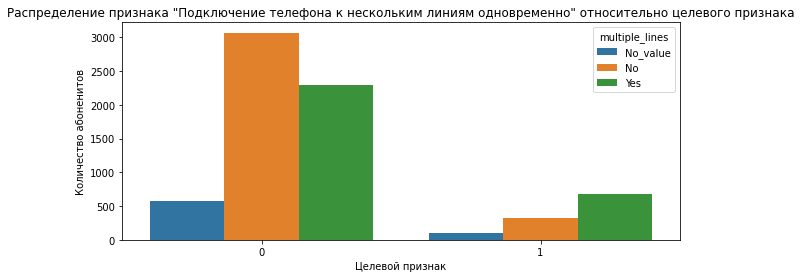

In [67]:
# перебираем в цикле элементы словаря и смотрим распределение категориальых признаков, строим bsr plot
for feature, feature_name in features_name.items():
    if feature in categorical_features:
        print('#' * 21)
        print('##', feature, '##')
        print('#' * 21)   
        class_0 = data_full.loc[data_full['exited'] == 0, feature] 
        class_1 = data_full.loc[data_full['exited'] == 1, feature] 
        class_0 = class_0.rename('Класс 0 (активные абоненты)') 
        class_1 = class_1.rename('Класс 1 (ушедшие абоненты)')                
        display(pd.DataFrame([class_0.value_counts(normalize=True), class_1.value_counts(normalize=True)]))
        print()
        # Bar plot для признаков
        plt.figure(figsize=(10, 4))
        sns.countplot(data=data_full, x="exited", hue=feature)
        plt.xlabel('Целевой признак')
        plt.ylabel('Количество абоненитов')
        plt.title(f'Распределение признака "{feature_name}" относительно целевого признака')
        plt.show()

При анализе распределения признака `partner` относительно целевого признака видим, что среди разорвавших договор абонентов 65% людей, у которых есть партнер, среди же действующих абонентов людей, у которых есть партнер - 45%, то есть чаще уходят клиенты, у которых есть партнер.

Анализ признака `type` показал, что среди ушедших абонентов доля клиентов, осуществляющих оплату помесячно, составляет 37%, что незначительно больше, чем доля клиентов, платящих раз в 2 года - 34%. Доля клиентов, платящих ежегодно - 28%. Что же касается действующих абонентов - соотношение меняется: абсолютным лидером являются клиенты, осуществляющие оплату помесячно - 58%, доля клиентов, платящих раз в 2 года - 22%, а доля клиентов, платящих ежегодно - 19%. Таким образом, несмотря на то, что клиенты, осуществляющие оплату помесячно уходят чаще других (клиентов с помесячной оплатой в общем больше, чем других), среди лояльных клиентов больше половины клиентов с помесячной оплатой.

Изменение в соотношении долей абонентов по признаку среди ушедших клиентов и действующих также замечено при анализе признака `payment_method`: среди активных абонентов незначительный перевес у клиентов с типом платежа "Electronic check" - 33%, на втором месте клиенты с типом оплаты "Mailed check", клиентов с типами оплаты "Bank transfer (automatic)" и "Credit card (automatic)" по 20%. При этом среди ушедших абонентов меньше всего клиентов с типом оплаты "Mailed check" - 11%, чуть уменьшилась доля клиентов с типом оплаты "Electronic check" - 31%, клиентов с типами оплаты "Bank transfer (automatic)" и "Credit card (automatic)" по 29%. Абоненты с типом оплаты "Mailed check" разрывают договор реже других.

Анализ данных по таким дополнительным услугам, как "Облачное хранилище файлов для резервного копирования данных" (`online_backup`), "Антивирус" (`device_protection`), "Стриминговое телевидение" (`streaming_tv`), "Каталог фильмов" (`streaming_movies`), "Подключение телефона к нескольким линиям одновременно" (`multiple_lines`) показал, что абоненты, пользующиеся такими услугами уходят чаще, чем абоненты, не использующие эти услуги, - возможно, качество услуг у оператора связи не удовлетворяют абонентов.

Посмотрим на распределение количественных признаков относительно целевого признака `exited`.

#####################
## monthly_charges ##
#####################


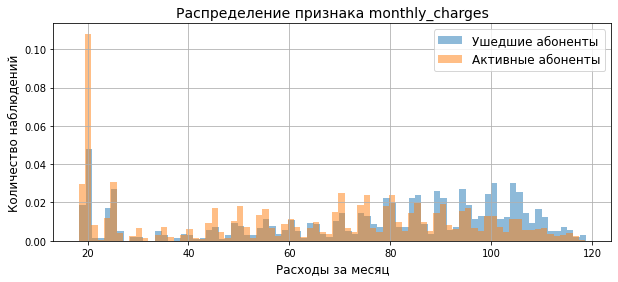


#####################
## total_charges ##
#####################


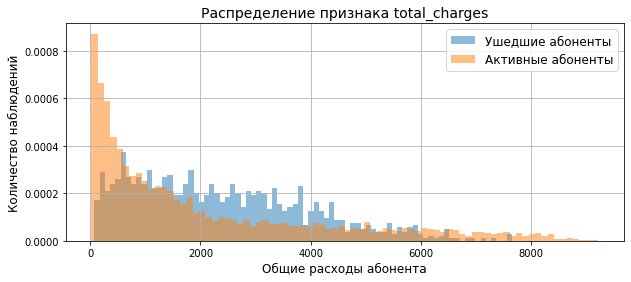


#####################
## duration ##
#####################


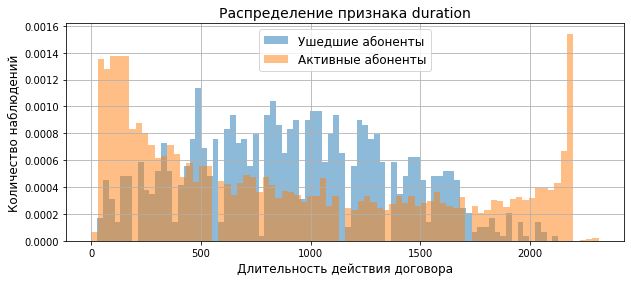

In [68]:
# перебираем в цикле элементы словаря и вызываем функцию для поиска выбросов в каждом из числовых признаков
for feature, feature_name in features_name.items():
    if feature in numeric_features:
        print('#' * 21)
        print('##', feature, '##')
        print('#' * 21)    
        data_full.loc[data_full['exited'] == 1][feature].hist(alpha=0.5,
                                         bins=80,
                                         figsize=(10, 4),
                                         density=True)
        data_full.loc[data_full['exited'] == 0][feature].hist(alpha=0.5,
                                        bins=80,
                                        figsize=(10, 4),
                                        density=True)
        plt.legend(['Ушедшие абоненты', 'Активные абоненты'], fontsize=12)
        plt.title(f'Распределение признака {feature}',fontsize=14)
        plt.xlabel(feature_name, fontsize=12)
        plt.ylabel('Количество наблюдений', fontsize=12)
        plt.show()
        print()

Проанализировав график стоит отметить:
- среди абонентов, тратящих на связь сумму, близку к минимальной ушедших клиентов меньше, чем среди клиентов, имеющих большие затраты. Однако, если опираться на признак `total_charges` это может быть так же связано с длительностью договора;
- при анализе признака `monthly_charges` так же можно сделать вывод о том, что абоненты, имеющие небольшие расходы в месяц уходят реже, чем абоненты, имеющие большие месячные затраты - пик ушедших "богатых" клиентов приходитсяна 100-105 в месяц;
- количество ушедших среди абонентов, недавно заключивших договор (примерно до 250 дней со дня заключения договора), и среди лояльных абонентов (заключивших договор более примерно 1700 дней назад) меньше, чаще всего абоненты разрывают контракт в промежутке 500-1200 дней со дня заключения договора.

Проведем анализ мультиколлинеарности признаков.

In [69]:
# посмтроим матрицу корреляции с помощью методов библиотеки Phik
multicollinearity = data_full.phik_matrix(interval_cols=numeric_features)
display(multicollinearity)

,type,paperless_billing,payment_method,monthly_charges,total_charges,exited,duration,gender,senior_citizen,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines
type,1.000000,0.106860,0.277462,0.388444,0.468471,0.094015,0.634155,0.000000,0.086231,0.179736,0.147680,0.505187,0.636884,0.581660,0.631531,0.671629,0.549564,0.553556,0.244410
paperless_billing,0.106860,1.000000,0.370495,0.467812,0.203144,0.083398,0.026799,0.000000,0.242133,0.013218,0.172593,0.231438,0.208320,0.195321,0.195687,0.200621,0.204717,0.202241,0.099953
payment_method,0.277462,0.370495,1.000000,0.399526,0.335175,0.214832,0.350964,0.000000,0.292725,0.243008,0.224903,0.323886,0.315799,0.293413,0.297923,0.317713,0.284531,0.285525,0.174849
monthly_charges,0.388444,0.467812,0.399526,1.000000,0.711029,0.226280,0.387727,0.008175,0.304985,0.203545,0.184366,0.919002,0.812632,0.818851,0.827272,0.816660,0.864677,0.863616,0.709983
total_charges,0.468471,0.203144,0.335175,0.711029,1.000000,0.304287,0.847414,0.000000,0.137707,0.381042,0.082134,0.489674,0.516119,0.550225,0.558342,0.527587,0.555337,0.554238,0.467339
exited,0.094015,0.083398,0.214832,0.226280,0.304287,1.000000,0.374569,0.008581,0.086159,0.226688,0.046871,0.056621,0.058659,0.089704,0.085608,0.051537,0.078545,0.086577,0.105101
duration,0.634155,0.026799,0.350964,0.387727,0.847414,0.374569,1.000000,0.000000,0.063315,0.453688,0.198729,0.060845,0.346398,0.366170,0.374702,0.353438,0.306675,0.307297,0.347289
gender,0.000000,0.000000,0.000000,0.008175,0.000000,0.008581,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.001460,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
senior_citizen,0.086231,0.242133,0.292725,0.304985,0.137707,0.086159,0.063315,0.000000,1.000000,0.016992,0.324576,0.160702,0.127319,0.109995,0.110177,0.135283,0.111714,0.113778,0.087925
partner,0.179736,0.013218,0.243008,0.203545,0.381042,0.226688,0.453688,0.000000,0.016992,1.000000,0.652122,0.000000,0.091202,0.092012,0.100092,0.076326,0.082251,0.077506,0.086249


Построим тепловую карту для наглядности.

<AxesSubplot:>

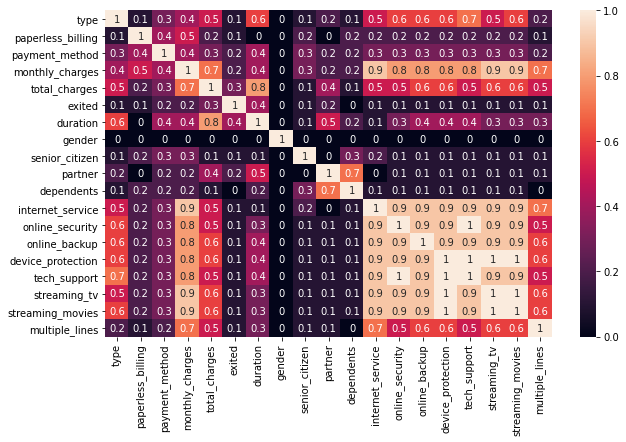

In [70]:
# тепловая карта для матрицы корреляции (округлим коэффициенты корреляции)
sns.heatmap(multicollinearity.copy().round(1), annot=True)

Видим, что в данных есть проблема мультиколлинеарности - есть признаки с очень высокой корреляцией (больше 0.8). Так же есть признаки, например `gender`, у которых нет корреляции с целевым признаком. 

**Выводы:**
1. В результате анализа было выявлено:
- в датафрейме 19 столбцов: 3 числовых, 15 категориальных;
- есть пропуски в столбцах: в `internet_service`, `online_security`, `online_backup`, `device_protection`, `tech_support`, `streaming_tv`, `streaming_movies` по 1526 пропусков - 21% всех данных, в столбце `multiple_lines` 682 пропуска - 9%;
- дубликатов в категориальных полях нет;
- наблюдается дисбаланс класса в целевом признаке - положительного класса всего 16%;
- количественные признаки не имеют нормального распределения, признак `monthly_charges` имеет бимодальное распределение, в столбце `total_charges` есть выбросы;
- в некоторых категориальных признаках наблюдается дисбаланс;
- некоторые зависимости между целевым признаком и другими признаками:
    - клиенты с помесячной оплатой уходят чаще;
    - абоненты с типом оплаты "Electronic check" чаще разрывают договор;
    - абоненты, использующие такие дополнительные услуги, как "Облачное хранилище файлов для резервного копирования данных", "Антивирус", "Стриминговое телевидение", "Каталог фильмов", "Подключение телефона к нескольким линиям одновременно", уходят чаще, чем абоненты, не использующие эти услуги, - возможно, качество услуг у оператора связи не удовлетворяют абонентов;
    - абоненты, имеющие небольшие расходы в месяц уходят реже, чем абоненты, имеющие большие месячные затраты - пик ушедших "богатых" клиентов приходитсяна 100-105 в месяц;
    - меньше всего ушедших абонентов среди недавно заключивших договор (примерно до 250 дней со дня заключения договора) и среди лояльных (заключивших договор более примерно 1700 дней назад), чаще всего абоненты разрывают контракт в промежутке 500-1200 дней со дня заключения договора;
- есть признаки с очень высокой коллинеарностью (больше 0.8).
2. В результате предобработки были заменены пропуски значением "No_value".

## Подготовка данных

Для борьбы с мультиколлинеарностью удалим признаки с очень высокой корреляцией (больше 0.8) с другими признаками, при выборе между коррелирующими признаками будем смотреть на более высокую корреляцию с целевым признаком. Так же отбросим признаки, которые практически не коррелируют с целевым признаком -, чтобы не потерять слишком много данных, выберем невысокий порог - корреляция с целевым признаком должна быть не ниже 0.03.

Чтобы избежать утечки данных перед отбором признаков разделим данные на 2 выборки - обучающую и тестовую в соотношении 75:25.

In [71]:
# отделим 25% данных для валидационной выборки
data_train, data_test = train_test_split(data_full, test_size=0.25, 
                                         stratify = data_full['exited'], random_state=MY_RANDOM_STATE) 

Проверим получившиеся выборки.

In [72]:
print('Размерность обучающей выборки')
print(data_train.shape)
print()
print('Размерность тестовой выборки')
print(data_test.shape)

Размерность обучающей выборки
(5282, 19)

Размерность тестовой выборки
(1761, 19)


Выборки поделены корректно.

Выберем признаки, которые будем использовать для обучения модели.

In [73]:
# посмтроим матрицу корреляции с помощью методов библиотеки Phik
multicollinearity = data_train.phik_matrix(interval_cols=numeric_features)
display(multicollinearity)

,type,paperless_billing,payment_method,monthly_charges,total_charges,exited,duration,gender,senior_citizen,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines
type,1.000000,0.109411,0.272860,0.401260,0.478938,0.089812,0.640057,0.000000,0.081314,0.180322,0.148234,0.505445,0.633686,0.587359,0.634461,0.671375,0.553581,0.555944,0.258436
paperless_billing,0.109411,1.000000,0.372873,0.464998,0.199777,0.088714,0.049432,0.015658,0.262746,0.024443,0.191323,0.230303,0.206852,0.194195,0.194676,0.200281,0.205616,0.201136,0.100530
payment_method,0.272860,0.372873,1.000000,0.407834,0.345723,0.208823,0.354227,0.000000,0.270275,0.237557,0.225710,0.328691,0.313456,0.293565,0.297587,0.316353,0.286217,0.287852,0.175597
monthly_charges,0.401260,0.464998,0.407834,1.000000,0.712569,0.243006,0.392587,0.000000,0.292635,0.189384,0.189509,0.919599,0.811913,0.817691,0.826701,0.817653,0.864212,0.863969,0.703896
total_charges,0.478938,0.199777,0.345723,0.712569,1.000000,0.305779,0.847990,0.000000,0.128050,0.383583,0.084075,0.480417,0.514449,0.549326,0.556592,0.524220,0.553904,0.547109,0.458522
exited,0.089812,0.088714,0.208823,0.243006,0.305779,1.000000,0.371068,0.000000,0.093713,0.209401,0.049682,0.066652,0.060423,0.092880,0.087123,0.055743,0.083082,0.093048,0.108539
duration,0.640057,0.049432,0.354227,0.392587,0.847990,0.371068,1.000000,0.000000,0.065846,0.455304,0.195640,0.082047,0.353644,0.374846,0.378501,0.355533,0.311364,0.296402,0.343302
gender,0.000000,0.015658,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
senior_citizen,0.081314,0.262746,0.270275,0.292635,0.128050,0.093713,0.065846,0.000000,1.000000,0.031194,0.314967,0.151387,0.120404,0.103443,0.103638,0.126304,0.105607,0.107269,0.080645
partner,0.180322,0.024443,0.237557,0.189384,0.383583,0.209401,0.455304,0.000000,0.031194,1.000000,0.644531,0.000000,0.087679,0.089601,0.100035,0.075241,0.079656,0.073698,0.079777


<AxesSubplot:>

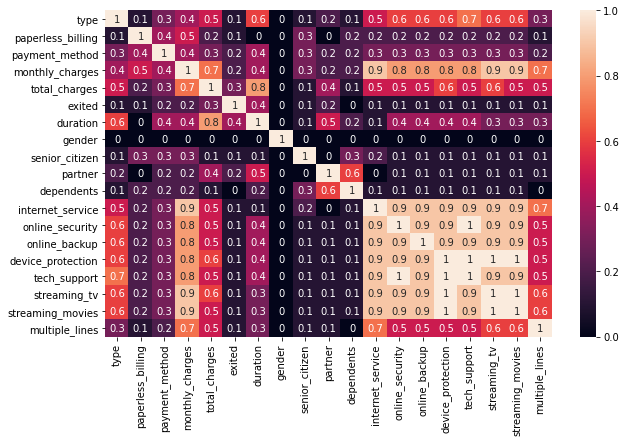

In [74]:
# тепловая карта для матрицы корреляции (округлим коэффициенты корреляции)
sns.heatmap(multicollinearity.copy().round(1), annot=True)

Видим, что есть ряд признаков с сильной корреляцией:
1. Среди признаков `internet_service`, `monthy_charges`, `online_security`, `online_backup`, `device_protection`, `tech_support`, `streaming_tv`, `streaming_movies` оставим признак `monthy_charges` - у него самая сильная корреляция с целевым признаком (0.24).
2. Сильная корреляция наблюдается между признаками `total_charges` и `duration` - оставим признак `duration`, как признак с более сильной корреляцией с целевым признаком (0.4).
3. Так же видим, что признак `gender` имеет нулевую корреляцию с целевым признаком - не будем его использовать.

Таким образом, сформируем список признаков, которые мы будем использовать для обучения моделей.

In [75]:
columns = ['type',
 'paperless_billing',
 'payment_method',
 'monthly_charges',
 'duration',
 'senior_citizen',
 'partner',
 'dependents',
 'multiple_lines']

Среди отобранных признаков выделим числовые признаки и категориальные.

In [76]:
numeric_features=['monthly_charges', 'duration']
numeric_features

['monthly_charges', 'duration']

In [77]:
# отделяем категориальные признаки
categorical_features = [col for col in data_train[columns].columns if (col not in numeric_features 
                                                            and col != 'exited')] 
categorical_features

['type',
 'paperless_billing',
 'payment_method',
 'senior_citizen',
 'partner',
 'dependents',
 'multiple_lines']

Запишем в отдельные переменные признаки и целевой признак. Целевой признак - `exited` - запишем его в переменную `target`, признаки отобранные в предыдущем разделе, запишем в переменную `features`.

In [78]:
# запишем в переменную features_train признаки обучающей выборки
features_train = data_train[columns]
# запишем в переменную target_train целевой признак обучающей выборки
target_train = data_train['exited']
# запишем в переменную features_test признаки тестовой выборки
features_test = data_test[columns]
# запишем в переменную target_test целевой признак тестовой выборки
target_test = data_test['exited']

Еще раз проверим размерность выборок.

In [79]:
print('Размерность обучающей выборки')
print(features_train.shape)
print(target_train.shape)
print()
print('Размерность тестовой выборки')
print(features_test.shape)
print(target_test.shape)

Размерность обучающей выборки
(5282, 9)
(5282,)

Размерность тестовой выборки
(1761, 9)
(1761,)


Осталось только 9 признаков.

**Выводы:**
1. Для борьбы с мультиколлинеарностью были удалены признаки с очень высокой корреляцией (больше 0.8) с другими признаками, при выборе между коррелирующими признаками были оставлены признаки с более высокой корреляцией с целевым признаком.
2. Был удален признак с нулевой корреляцией с целевым признаков - `gender`.
3. Данные были поделены на 2 выборки - обучающую и тестовую в соотношении 75:25.

## Обучение моделей машинного обучения

Как мы уже выяснили раннее нам потребуется масштабирование признаков. Для этого проведем стандартизацию данных с помощью StandardScaler.

Категориальные данные будем преобразовывать тремя способами - для разных алгоритмов:
- OneHotEncoder - подойдет для регрессии (удалим первую категорию, чтобы не было коллинеарных признаков (drop='first'), игнорируем ошибку "неизвестная категория" (handle_unknown='ignore'));
- OrdinalEncoder - используем для решающих деревьев и градиентного бустинга.

### LogisticRegression

Обучим модель логистической регрессии и посчитаем метрику ROC AUC.

In [80]:
%%time
# обучим модель логистической регрессии
# преобразование признаков
col_transformer_lr = ColumnTransformer([
    (
        'ohe', OneHotEncoder(drop='first', handle_unknown='ignore'),# кодирование категорий OneHotEncoder
        categorical_features
    ),
    (
        'std', StandardScaler(),# масштабирование признаков
        numeric_features
    )],
    remainder='passthrough',
    verbose_feature_names_out=False
)
# модель
model_lr = LogisticRegression(random_state=MY_RANDOM_STATE)
# Pipeline
pipeline_lr = Pipeline([('transform', col_transformer_lr), 
                        ('clf', model_lr)])
# инициализация параметров для GridSearchCV
params_lr = {}
# запускаем функцию для подбора гиперпараметров и обучения модели
grid_model_lr = training(pipeline_lr, params_lr, features_train, target_train)

Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 1/3] END ..................................., score=0.763 total time=   0.3s
[CV 2/3] END ..................................., score=0.749 total time=   0.6s
[CV 3/3] END ..................................., score=0.716 total time=   0.4s
Лучший результат (ROC AUC): 0.7426309056336134
Лучшие параметры: {}
CPU times: user 827 ms, sys: 750 ms, total: 1.58 s
Wall time: 1.56 s


Построим ROC-кривую и PR-кривую.

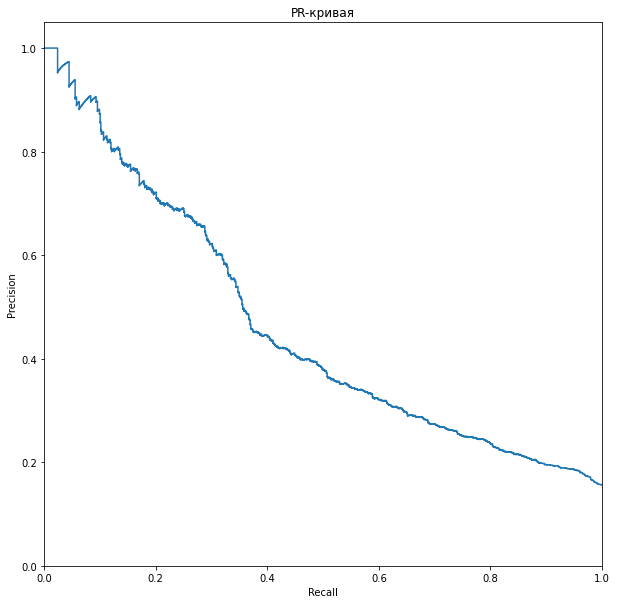

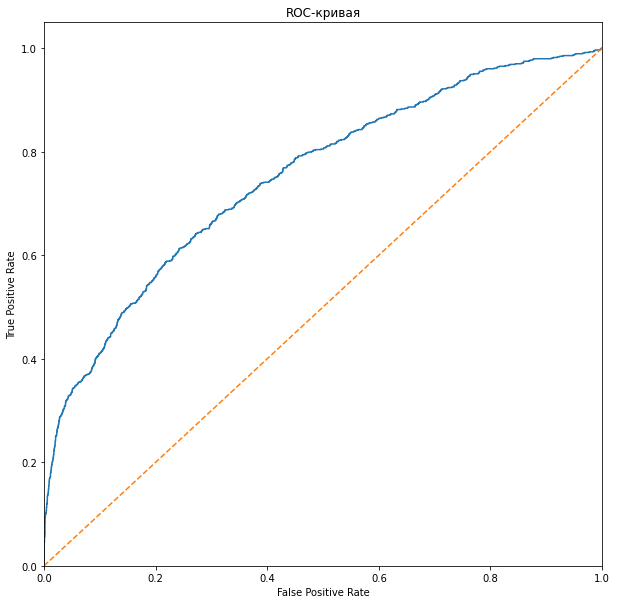

In [81]:
ml_threshold(grid_model_lr, [features_train, target_train])

Видим, что модель логистической регрессии не удовлетворяет требованиям по метрике ROC AUC - наилучший полученный результат - 0.74.

### DecisionTreeClassifier

Обучим модели дерево решений, при этом меняя гиперпараметр  - `max_depth` - глубина дерева. Переберем значения от 1 до 20.

In [82]:
%%time
# рассчитаем модель решающего дерева
# преобразование признаков
col_transformer_dt = ColumnTransformer([
    (
        'ohe', OrdinalEncoder(),# кодирование категорий через OrdinalEncoder
        categorical_features
    ),
    (
        'std', StandardScaler(),# приведение к нормальному распределению
        numeric_features
    )],
    remainder='passthrough',
    verbose_feature_names_out=False
)
# модель
model_dt = DecisionTreeClassifier(random_state=MY_RANDOM_STATE)
# Pipeline
pipeline_dt = Pipeline([('transform', col_transformer_dt), 
                        ('clf', model_dt)])
# инициализация параметров для GridSearchCV
params_dt = [{'clf__max_depth': range(1,21)}]
# запускаем функцию для подбора гиперпараметров и обучения модели
grid_model_dt = training(pipeline_dt, params_dt, features_train, target_train)

Fitting 3 folds for each of 20 candidates, totalling 60 fits
[CV 1/3] END ..................clf__max_depth=1;, score=0.574 total time=   0.0s
[CV 2/3] END ..................clf__max_depth=1;, score=0.578 total time=   0.0s
[CV 3/3] END ..................clf__max_depth=1;, score=0.616 total time=   0.0s
[CV 1/3] END ..................clf__max_depth=2;, score=0.694 total time=   0.0s
[CV 2/3] END ..................clf__max_depth=2;, score=0.694 total time=   0.0s
[CV 3/3] END ..................clf__max_depth=2;, score=0.712 total time=   0.0s
[CV 1/3] END ..................clf__max_depth=3;, score=0.735 total time=   0.0s
[CV 2/3] END ..................clf__max_depth=3;, score=0.748 total time=   0.0s
[CV 3/3] END ..................clf__max_depth=3;, score=0.746 total time=   0.0s
[CV 1/3] END ..................clf__max_depth=4;, score=0.765 total time=   0.0s
[CV 2/3] END ..................clf__max_depth=4;, score=0.803 total time=   0.0s
[CV 3/3] END ..................clf__max_depth=4;

Построим ROC-кривую и PR-кривую.

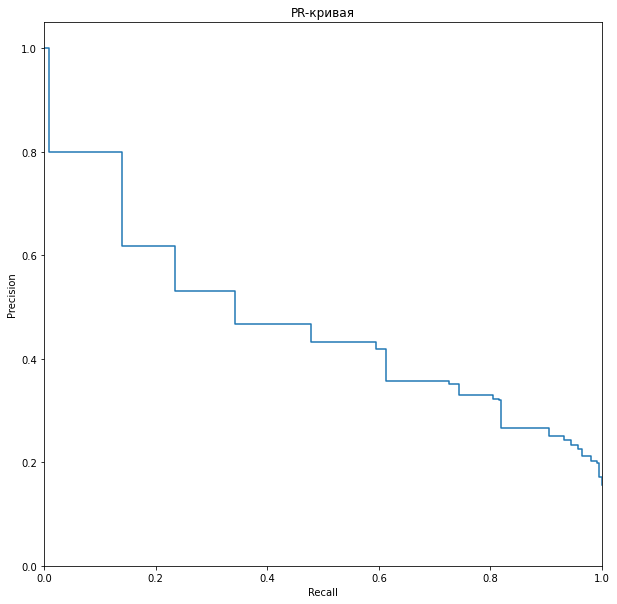

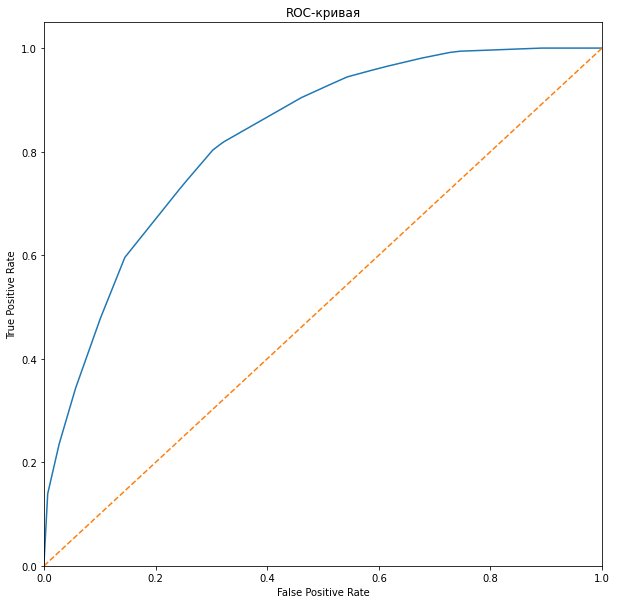

In [83]:
ml_threshold(grid_model_dt, [features_train, target_train])

Видим, что модель дерево решений не удовлетворяет требованиям по метрике ROC AUC - наилучший полученный результат - 0.79 при глубине дерева 5.

### RandomForestClassifier

Подберем оптимальные гиперпараметры для модели случайного леса, будем менять гиперпараметры следующим образом: - с количеством деревьев: от 10 до 100 с шагом 30 (n_estimators), - с максимальной глубиной: от 1 до 20 (max_depth).

In [84]:
%%time
# рассчитаем модель решающего дерева
# преобразование признаков
col_transformer_rf = ColumnTransformer([
    (
        'ohe', OrdinalEncoder(),# кодирование категорий через OrdinalEncoder
        categorical_features
    ),
    (
        'std', StandardScaler(),# приведение к нормальному распределению
        numeric_features
    )],
    remainder='passthrough',
    verbose_feature_names_out=False
)
# модель
model_rf = RandomForestClassifier(random_state=MY_RANDOM_STATE)
# Pipeline
pipeline_rf = Pipeline([('transform', col_transformer_rf), 
                        ('clf', model_rf)])
# инициализация параметров для GridSearchCV
params_rf = [{'clf__max_depth': range(1,21),
             'clf__n_estimators': range(10,101,30)}]
# запускаем функцию для подбора гиперпараметров и обучения модели
grid_model_rf = training(pipeline_rf, params_rf, features_train, target_train)

Fitting 3 folds for each of 80 candidates, totalling 240 fits
[CV 1/3] END clf__max_depth=1, clf__n_estimators=10;, score=0.655 total time=   0.1s
[CV 2/3] END clf__max_depth=1, clf__n_estimators=10;, score=0.676 total time=   0.0s
[CV 3/3] END clf__max_depth=1, clf__n_estimators=10;, score=0.722 total time=   0.0s
[CV 1/3] END clf__max_depth=1, clf__n_estimators=40;, score=0.676 total time=   0.1s
[CV 2/3] END clf__max_depth=1, clf__n_estimators=40;, score=0.722 total time=   0.1s
[CV 3/3] END clf__max_depth=1, clf__n_estimators=40;, score=0.760 total time=   0.1s
[CV 1/3] END clf__max_depth=1, clf__n_estimators=70;, score=0.685 total time=   0.2s
[CV 2/3] END clf__max_depth=1, clf__n_estimators=70;, score=0.705 total time=   0.2s
[CV 3/3] END clf__max_depth=1, clf__n_estimators=70;, score=0.716 total time=   0.2s
[CV 1/3] END clf__max_depth=1, clf__n_estimators=100;, score=0.682 total time=   0.2s
[CV 2/3] END clf__max_depth=1, clf__n_estimators=100;, score=0.708 total time=   0.2s
[

Построим ROC-кривую и PR-кривую.

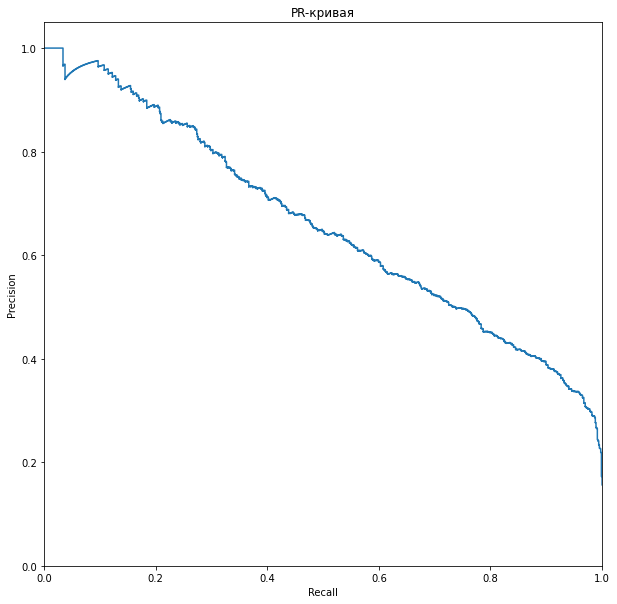

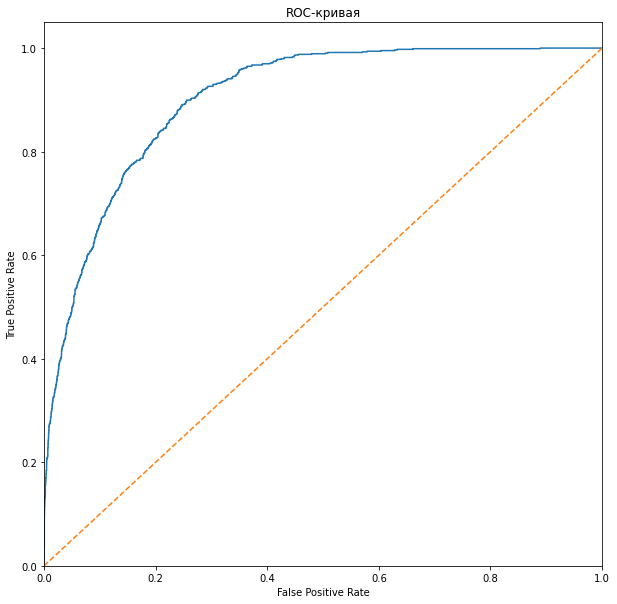

In [85]:
ml_threshold(grid_model_rf, [features_train, target_train])

Видим, что модель случайного леса не удовлетворяет требованиям по метрике ROC AUC - наилучший полученный результат - 0.82 при глубине дерева 7 и с количеством деревьев 70.

### LightGBM¶

Перейдем к моделям с градиентным бустингом. Для LightGBM рассмотрим следующие гиперпараметры:
- для `num_leaves` три значения: 70, 100, 150;
- `max_depth`: 25, 50, 75;
- `n_estimators`: 100,200;
- `learning_rate`: 0.05,0.1,0.2. 

Найдем оптимальные гиперпараметры с помощью GridSearchCV.

In [87]:
%%time
# рассчитаем модель решающего дерева
# преобразование признаков
col_transformer_lgbm = ColumnTransformer([
    (
        'ohe', OrdinalEncoder(),# кодирование категорий через OrdinalEncoder
        categorical_features
    ),
    (
        'std', StandardScaler(),# приведение к нормальному распределению
        numeric_features
    )],
    remainder='passthrough',
    verbose_feature_names_out=False
)
# модель
model_lgbm = LGBMClassifier(random_state=MY_RANDOM_STATE)
# Pipeline
pipeline_lgbm = Pipeline([('transform', col_transformer_lgbm), 
                        ('clf', model_lgbm)])
# инициализация параметров для GridSearchCV
params_lgbm = [{'clf__max_depth': [25, 50, 75],
               'clf__n_estimators': [100, 200],
               'clf__num_leaves': [70, 100, 150],
               'clf__learning_rate': [0.05, 0.1, 0.2],
               'clf__num_threads':[1]#Код ревьюера
               }]
# запускаем функцию для подбора гиперпараметров и обучения модели
grid_model_lgbm = training(pipeline_lgbm, params_lgbm, features_train, target_train)

Fitting 3 folds for each of 54 candidates, totalling 162 fits
[LightGBM] [Warning] num_threads is set=1, n_jobs=-1 will be ignored. Current value: num_threads=1
[CV 1/3] END clf__learning_rate=0.05, clf__max_depth=25, clf__n_estimators=100, clf__num_leaves=70, clf__num_threads=1;, score=0.833 total time=   0.2s
[LightGBM] [Warning] num_threads is set=1, n_jobs=-1 will be ignored. Current value: num_threads=1
[CV 2/3] END clf__learning_rate=0.05, clf__max_depth=25, clf__n_estimators=100, clf__num_leaves=70, clf__num_threads=1;, score=0.850 total time=   0.2s
[LightGBM] [Warning] num_threads is set=1, n_jobs=-1 will be ignored. Current value: num_threads=1
[CV 3/3] END clf__learning_rate=0.05, clf__max_depth=25, clf__n_estimators=100, clf__num_leaves=70, clf__num_threads=1;, score=0.832 total time=   0.2s
[LightGBM] [Warning] num_threads is set=1, n_jobs=-1 will be ignored. Current value: num_threads=1
[CV 1/3] END clf__learning_rate=0.05, clf__max_depth=25, clf__n_estimators=100, clf__n

Построим ROC-кривую и PR-кривую.

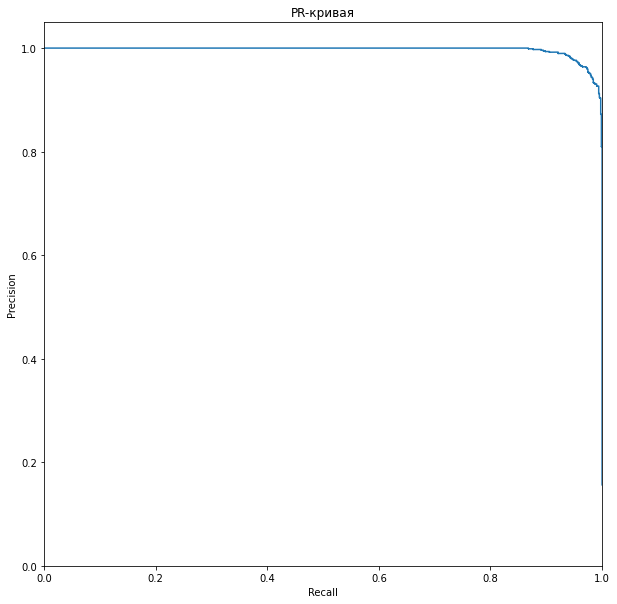

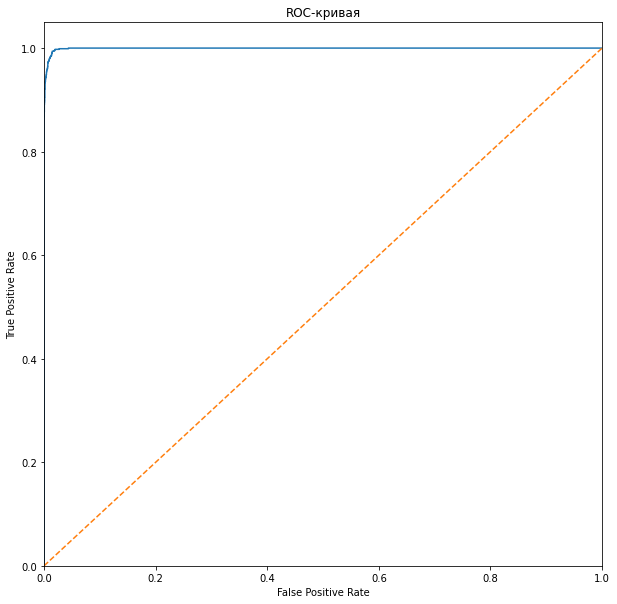

In [88]:
ml_threshold(grid_model_lgbm, [features_train, target_train])

Видим, что модель градиентного спуска LightGBM удовлетворяет требованиям по метрике ROC AUC - наилучший полученный результат - 0.86 при гиперпараметрах learning_rate=0.05, max_depth=75, n_estimators=200, num_leaves=70.

### CatBoostClassifier¶

Для CatBoostClassifier будем менять следующие гиперапарметры:
- скорость обучения (`learning_rate`) будет принимать значения: 0.001,0.5,0.999;
- количество деревьев в ансамбле (`n_estimators`): 500, 1000, 1500;
- глубину дерева `depth` будем менять от 1 до 15 с шагом 3.

In [89]:
%%time
# рассчитаем модель решающего дерева
# преобразование признаков
col_transformer_cbc = ColumnTransformer([
    (
        'ohe', OrdinalEncoder(),# кодирование категорий через OrdinalEncoder
        categorical_features
    ),
    (
        'std', StandardScaler(),# приведение к нормальному распределению
        numeric_features
    )],
    remainder='passthrough',
    verbose_feature_names_out=False
)
# модель
model_cbc = CatBoostClassifier(logging_level='Silent', random_state=MY_RANDOM_STATE)
# Pipeline
pipeline_cbc = Pipeline([('transform', col_transformer_cbc), 
                        ('clf', model_cbc)])
# инициализация параметров для GridSearchCV
params_cbc = [{'clf__depth': range(1,15,3),
               'clf__n_estimators': [500, 1000, 1500],
               'clf__learning_rate': [.001, .5, .999]}]
# запускаем функцию для подбора гиперпараметров и обучения модели
grid_model_cbc = training(pipeline_cbc, params_cbc, features_train, target_train)

Fitting 3 folds for each of 45 candidates, totalling 135 fits
[CV 1/3] END clf__depth=1, clf__learning_rate=0.001, clf__n_estimators=500;, score=0.743 total time=   1.0s
[CV 2/3] END clf__depth=1, clf__learning_rate=0.001, clf__n_estimators=500;, score=0.762 total time=   1.0s
[CV 3/3] END clf__depth=1, clf__learning_rate=0.001, clf__n_estimators=500;, score=0.769 total time=   1.0s
[CV 1/3] END clf__depth=1, clf__learning_rate=0.001, clf__n_estimators=1000;, score=0.773 total time=   1.4s
[CV 2/3] END clf__depth=1, clf__learning_rate=0.001, clf__n_estimators=1000;, score=0.782 total time=   1.3s
[CV 3/3] END clf__depth=1, clf__learning_rate=0.001, clf__n_estimators=1000;, score=0.783 total time=   1.3s
[CV 1/3] END clf__depth=1, clf__learning_rate=0.001, clf__n_estimators=1500;, score=0.792 total time=   1.7s
[CV 2/3] END clf__depth=1, clf__learning_rate=0.001, clf__n_estimators=1500;, score=0.796 total time=   1.8s
[CV 3/3] END clf__depth=1, clf__learning_rate=0.001, clf__n_estimator

Построим ROC-кривую и PR-кривую.

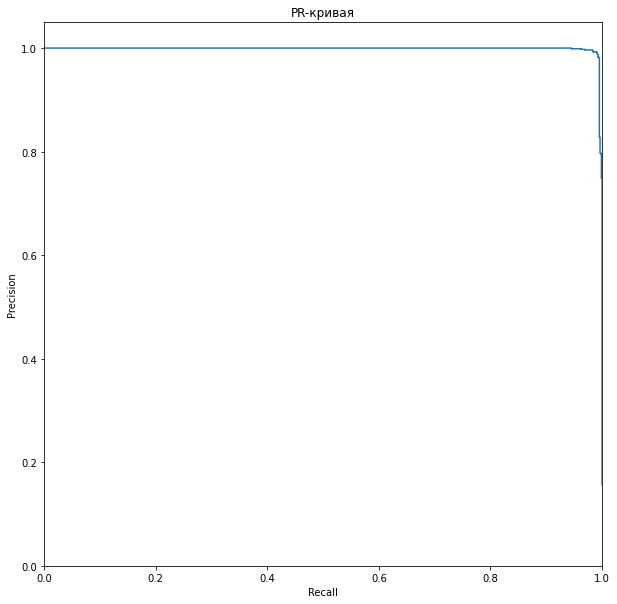

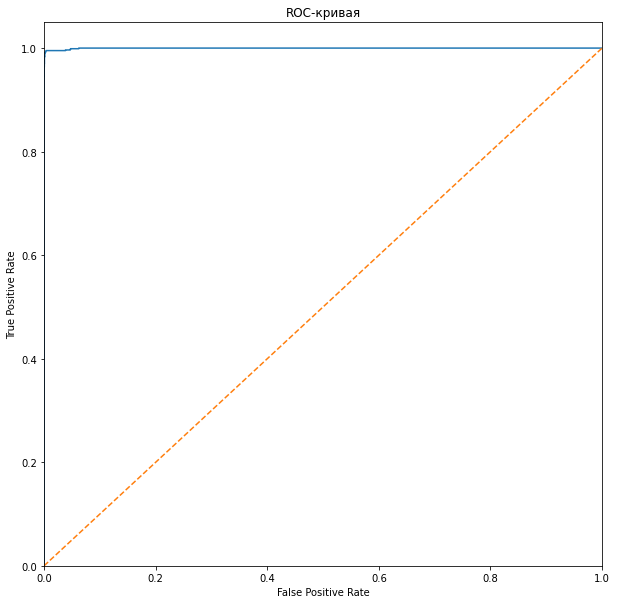

In [90]:
ml_threshold(grid_model_cbc, [features_train, target_train])

Видим, что модель градиентного спуска CatBoostClassifier удовлетворяет требованиям по метрике ROC AUC - наилучший полученный результат - 0.9 при гиперпараметрах depth=4, learning_rate=0.5, n_estimators=500.

### Выбор модели

Для тестирования выберем наилучшую модель - для этого построим таблицу по полученным метрикам

In [91]:
# сформируем сводную таблицу по метрике ROC AUC для всех моделей
# составим список обученных моделей
model_names = ['LogisticRegression', 
               'DecisionTreeClassifier', 
               'RandomForestClassifier', 
               'LightGBM', 
               'CatBoostClassifier']
score_table_roc_auc = pd.DataFrame(
    {'Модель': model_names, 
     'Метрика ROC AUC': [grid_model_lr.best_score_,
                        grid_model_dt.best_score_,
                        grid_model_rf.best_score_,
                        grid_model_lgbm.best_score_,
                        grid_model_cbc.best_score_]
    }
)               
score_table_roc_auc

,Модель,Метрика ROC AUC
0,LogisticRegression,0.742631
1,DecisionTreeClassifier,0.798098
2,RandomForestClassifier,0.826019
3,LightGBM,0.868412
4,CatBoostClassifier,0.907270


**Выводы:**
1. Перед обучением моделей числовые признаки были масштабированы с помощью StandardScaler, категориальные признаки закодированы: для регрессии - с помощью OneHotEncoder, для решающих деревьев и градиентного бустинга - OrdinalEncoder.
2. Модель логистической регрессии показала наилучший результат - 0.74.
3. Модель дерево решений показала наилучший результат - 0.79 при глубине дерева 5.
4. Модель случайного леса показала наилучшую метрику ROC AUC - 0.82 при глубине дерева 7 и с количеством деревьев 70.
5. Модель градиентного спуска LightGBM показала наилучший результат - 0.86 при гиперпараметрах learning_rate=0.05, max_depth=75, n_estimators=200, num_leaves=70.
6. Модель градиентного спуска CatBoostClassifier показала наилучший результат - 0.9 при гиперпараметрах depth=4, learning_rate=0.5, n_estimators=500.
7. Из всех моделей, только модели градиентного спуска показали результат, удовлетворяющий требованию - ROC AUC не ниже 0.85. Наилучшей моделью оказалась модель градиентного спуска CatBoostClassifier.

## Тестирование модели

В предыдущем разделе было решено выбрать модель с самой лучшей метрикой ROC AUC - это модель градиентного бустинга CatBoostClassifier с гиперпараметрами 'learning_rate': 0.2, 'num_leaves': 150. Протестируем ее на тестовой выборке.

In [92]:
%%time

# Предсказание лучшей модели
predict = grid_model_cbc.predict(features_test)
predict_proba = grid_model_cbc.predict_proba(features_test)

CPU times: user 27.4 ms, sys: 0 ns, total: 27.4 ms
Wall time: 26.4 ms


Посчитаем метрику ROC AUC.

In [93]:
# расчет ROC AUC
roc_auc = roc_auc_score(target_test, predict_proba[:, 1])
print('Показатель ROC AUC:', roc_auc)

Показатель ROC AUC: 0.9386871405848525


Построим ROC-кривую и PR-кривую.

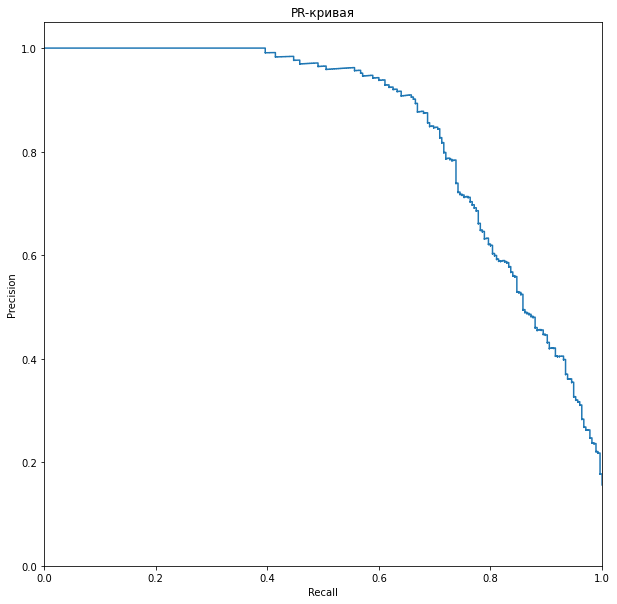

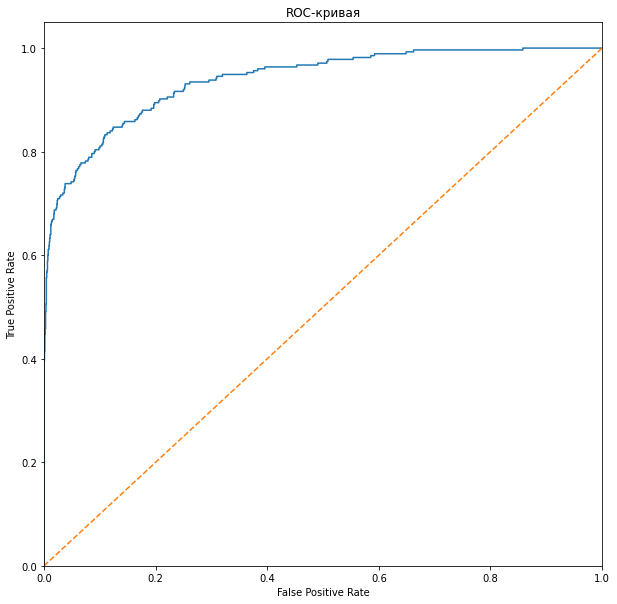

In [94]:
ml_threshold(grid_model_cbc, [features_test, target_test])

ROC-кривая очень сильно выпуклая вверх, то есть под ней вписана большая часть прямоугольника, что означает, что модель в большинстве случаев правильно предсказывает целевые значения.

Посчитаем метрику Accuracy.

In [95]:
# расчет метрики Accuracy
print('Показатель Accuracy:', accuracy_score(target_test, predict)) 

Показатель Accuracy: 0.9352640545144804


Построим матрицу ошибок.

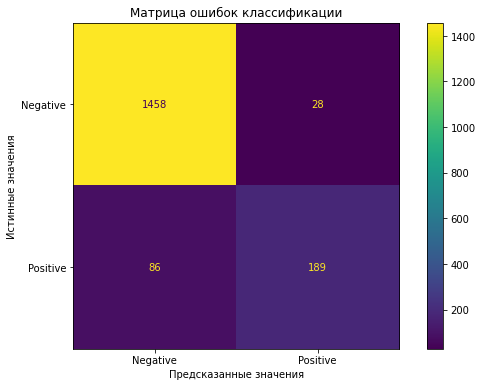

In [96]:
# матрица ошибок
cm = confusion_matrix(target_test, predict)
cm_df = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Negative", "Positive"])
cm_df.plot()
plt.title('Матрица ошибок классификации')
plt.xlabel('Предсказанные значения')
plt.ylabel('Истинные значения')
plt.show()

По матрице ошибок видно, что выбранная модель хорошо предсказывает класс «Negative» (0) - большая часть предсказаний по этому классу верна. Что же касается предсказания класса «Positive» (1) - то доля верных предсказаний гораздо ниже - около 68%. Таким образом, модель хорошо справляется с предсказаниями лояльного абонента - который не собирается уходить, и только в 68: правильно предскажет абонента, который расторгнет договор.

Получим оценки важности функции при моделировании CatBoostClassifier.

In [97]:
# Анализ важности признаков
cbc_importances = pd.DataFrame(
    grid_model_cbc.best_estimator_[-1].feature_importances_, 
    index=grid_model_cbc.best_estimator_[:-1].get_feature_names_out(),
    columns=['Важность признака']
).sort_values(by='Важность признака', ascending=False)

Для наглядности построим диаграмму важности факторов при моделировании CatBoostClassifier.

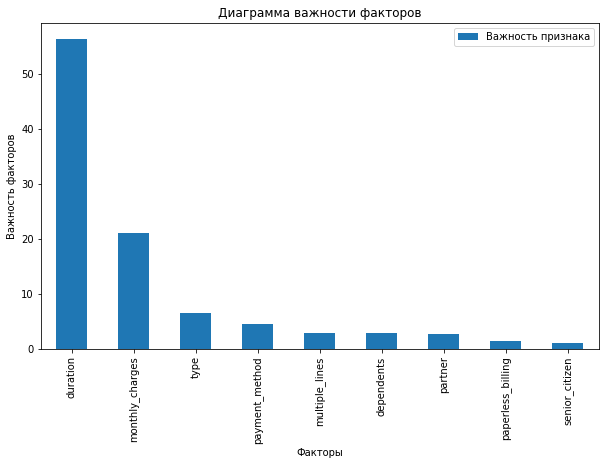

In [98]:
cbc_importances.plot.bar() # строим возрастающую столбчатую диаграмму
# указываем наименования осей и графика
plt.xlabel('Факторы')
plt.ylabel('Важность факторов')
plt.title('Диаграмма важности факторов')
plt.show()

Видим что при моделировании CatBoostClassifier несомненным лидером по важности признаков оказался признак "длительность договора". Так же достаточно важным оказался признак "расходы за месяц" и "тип оплаты: раз в год-два или ежемесячно". Меньше всего из выбранных признаков на целевой признак влияет "является ли абонент пенсионером".

**Выводы:**
1. ROC AUC наилучшей модели на тестовой выборке - 0.93, Accuracy - 0.93.
2. Модель хорошо предсказывает лояльных абонентов - которые не собираются уходить, и только в 68% правильно предсказывает абонента, который расторгнет договор.
3. Больше всего на факт ухода клиента влияют такие признаки, как: "длительность договора", "расходы за месяц" и "тип оплаты: раз в год-два или ежемесячно". Самым незначительным является признак "является ли абонент пенсионером".

## Общий вывод

1. Мы провели исследовательский анализ и предобработку данных исходных датафреймов `contract_new` (информация о договоре), `personal_new` (персональные данные клиента), `internet_new` (информация об интернет-услугах) и `phone_new `(информация об услугах телефонии): 
- были обнаружены и заполнены "неявные" пропуски (пробелы) в столбце `TotalCharges` на данные из столбца `MonthlyCharges`;
- были обнаружены и преобразованы некорректные типы данных (столбцы `TotalCharges`, `EndDate`, `BeginDate`, `SeniorCitizen`);
- были созданы новые признаки: `duration` - длительность договора, `existed` - ушел ли клиент или нет - целевой признак;
- удалены признаки с датой `EndDate` и `BeginDate`;
- названия признаков приведены к «змеиному стилю».
2. Данные объединили в один датафрейм и провели исследовательский анализ и предобработку данных объединенного датафрейма:
- были обнаружены и заполнены пропуски в 8 категориальных столбцах - добавлена новая категория;
- был удален неинформативный признак `customer_id`;
- была обнаружена проблема мультиколлинеарности - есть признаки с высокой корреляцией (больше 0.8);
- был выявлен дисбаланс классов (объектов положительного класса всего 16% от всей выборки).

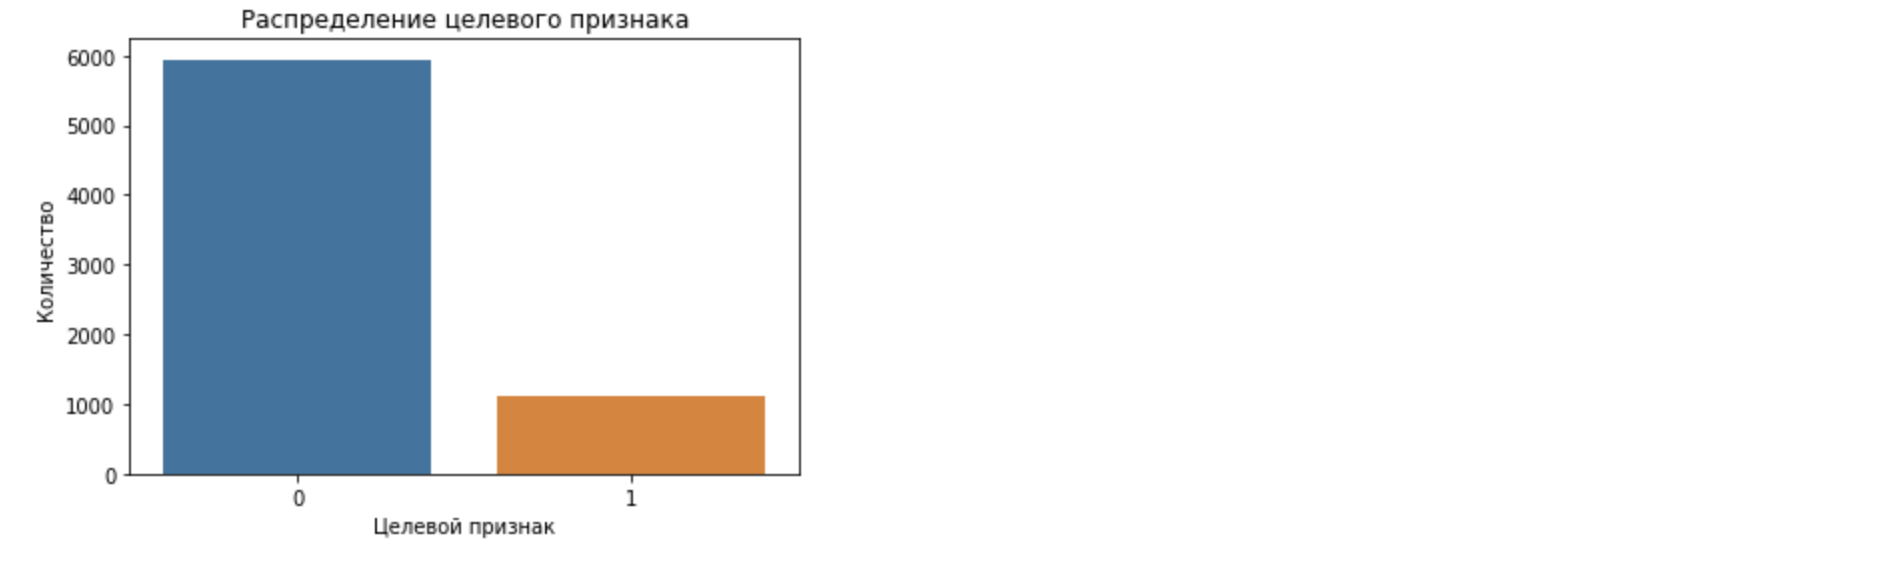

3. Была осуществлена попытка найти связь между целевым признаком и другими. Выяснили, что:
- чаще всего абоненты разрывают договора после примерно 250 дней, со временем (примерно после 4 лет) вероятность отказа от услуг снижается;
- обычно отказываются от услуг абоненты, которые имеют большие расходы за месяц (около 100).

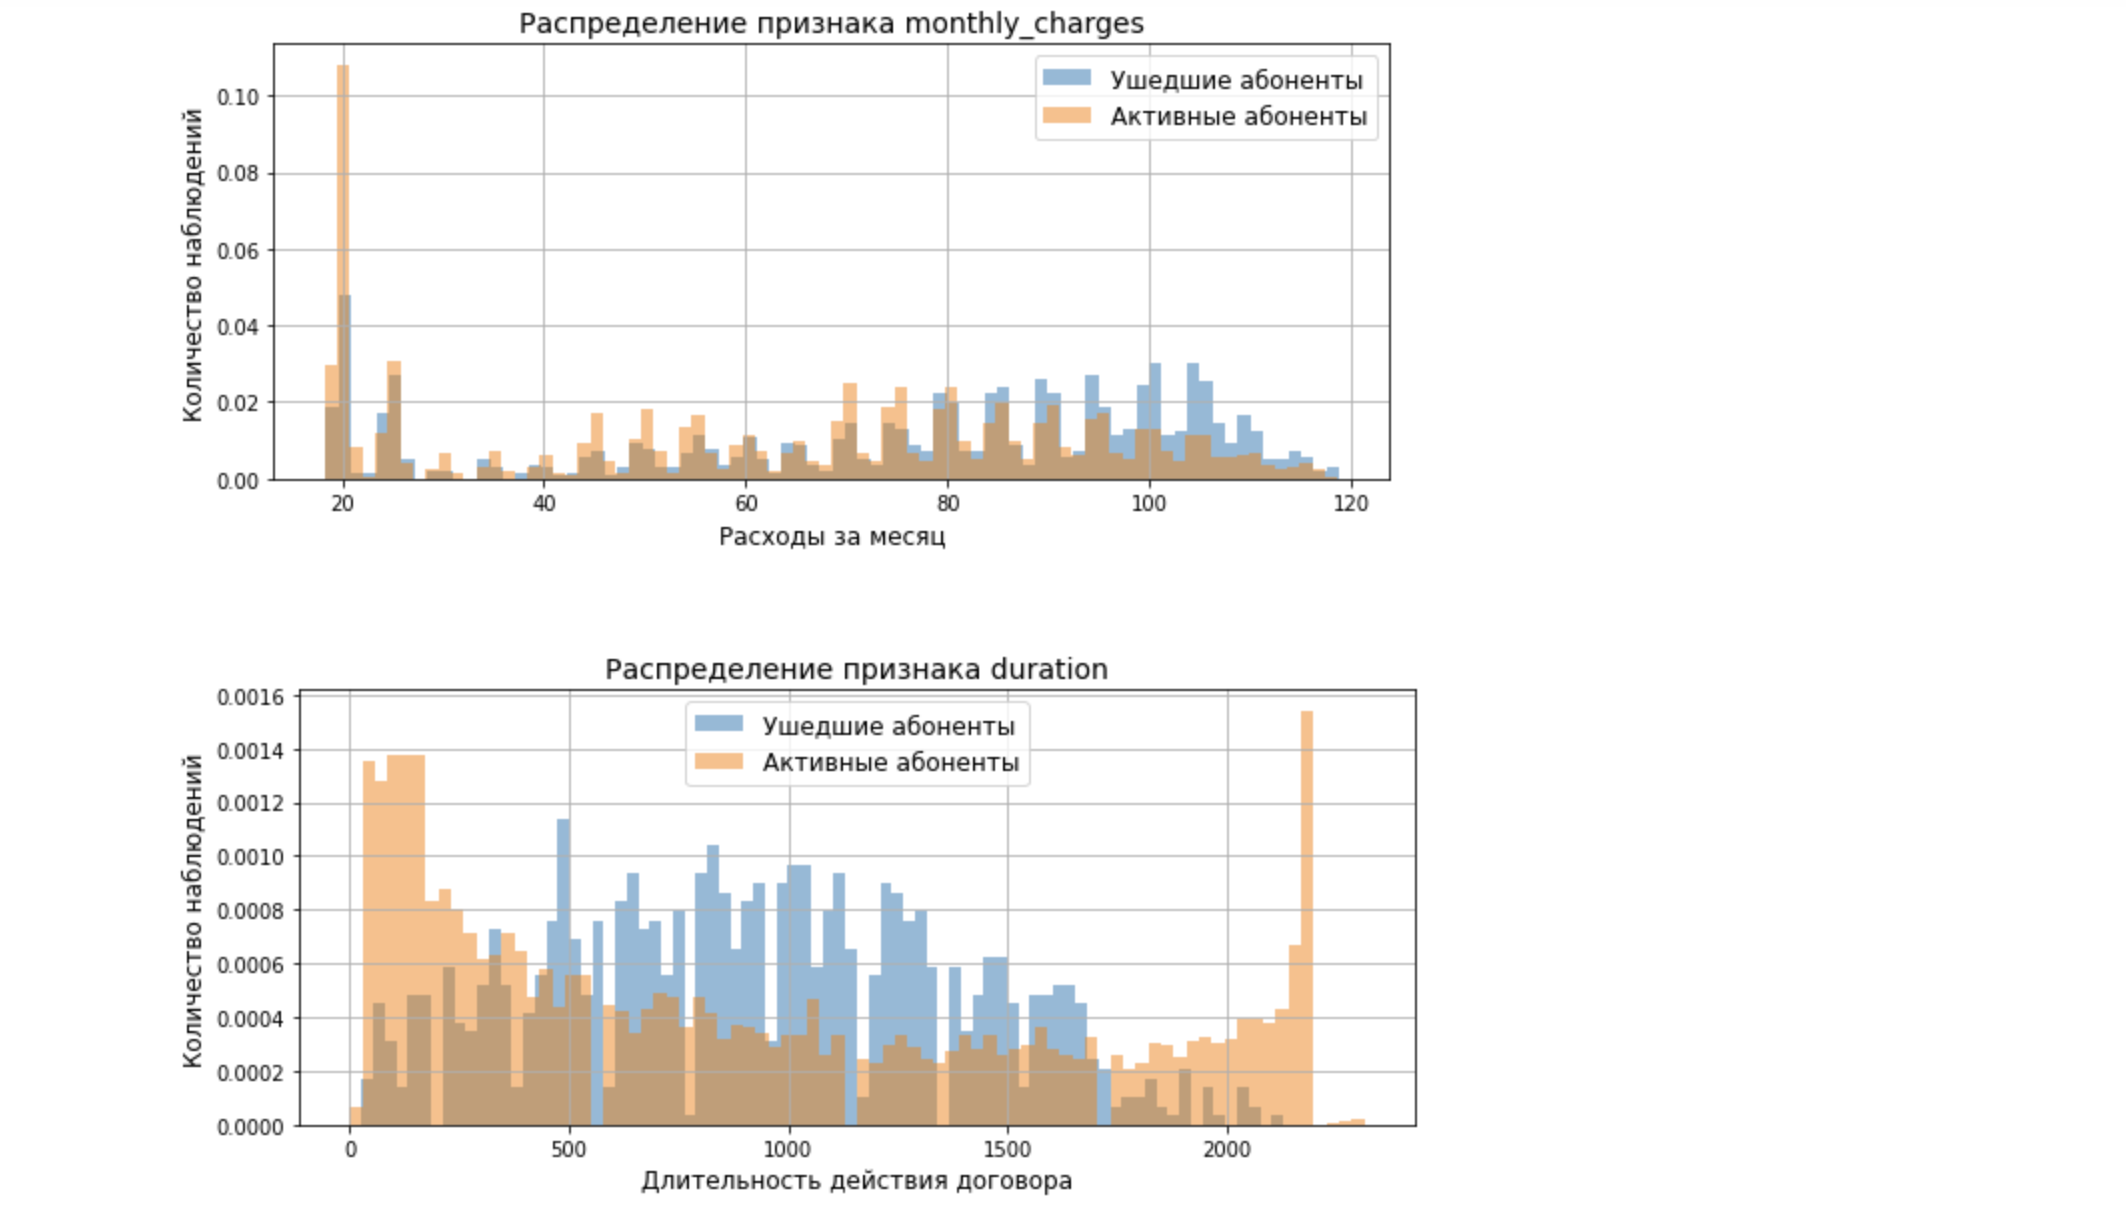

4. Целевым признаком определили данные о факте ухода абонента - `duration`. Разбили данные на 2 выборки в соотношении 75:25 - обучающую и тестовую. Данные были разбиты с учетом стратификации - случайного выбора объектов.
5. Для борьбы с мультиколлинеарностью были удалены признаки с очень высокой корреляцией (больше 0.8) с другими признаками, был удален признак с нулевой корреляцией с целевым признаков -  `gender` (были оставлены 9 признаков).
6. Для данных были выбраны следующие методы обработки:
- для категориальных признаков:
    - для регрессии - преобразование в численные с помощью техники прямого кодирования - OneHotEncoder с параметрами `drop='first'` (помогает избежать "ловушки фиктивных признаков") и `handle_unknown='ignore'`;
    - OrdinalEncoder - для решающих деревьев и градиентного бустинга;
- для числовых признаков - стандартизация данных с помощью StandardScaler.
7. Задача была определена, как бинарная классификация. Для решения задачи были применены и исследованы пять вариантов моделирования: дерево решений, случайный лес, логистическая регрессия, градиентный бустинг (LightGBM, CatBoostClassifier). На тестовой выборке кросс-валидацией были подобраны оптимальные гиперпараметры и посчитана метрика ROC AUC:
- модель `Logistic Regression` была проанализирована в одном варианте. Модель логистической регрессии в этой задаче показала самые плохие результаты: ROC AUC=0.74;
- для моделей `Decision Tree` были проанализированы 20 вариантов: с гиперпараметром `max_depth` - максимальная глубина дерева - от 1 до 20. Наилучший результат модель случайного леса показала при гиперпараметрt 'max_depth'=5: ROC AUC = 0.79;
- для моделей `Random Forest` было проанализировано 80 вариантов: с гиперпараметром `n_estimators` - количество деревьев - от 10 до 100 с шагом 30, и гиперпараметром `max_depth` - максимальная глубина - от 1 до 20. Наилучший результат модель случайного леса на валидационной выборке показала при гиперпараметрах 'max_depth'=7, 'n_estimators'=70:  ROC AUC = 0.82;
- для моделей `LightGBM` было проанализировано 54 варианта: с гиперпараметрами для `num_leaves` - 70, 100, 150, `max_depth` - 25, 50, 75, `n_estimators` - 100,200, `learning_rate` - 0.05,0.1,0.2. Наилучший результат модель градиентного бустинга на валидационной выборке показала при гиперпараметрах 'learning_rate'=0.05, 'max_depth'=75, 'n_estimators'=200, 'num_leaves'=70:  ROC AUC = 0.86;
- для модели `CatBoostRegressor` было проанализировано 45 вариантов: скорость обучения (`learning_rate`): 0.001,0.5,0.999, количество деревьев в ансамбле (`n_estimators`): 500, 1000, 1500, глубина дерева `depth` от 1 до 15 с шагом 3. Наилучший результат показала модель с гиперпараметрами 'depth'=4, n_estimators=500, 'learning_rate'= 0.5: ROC AUC=0.9.
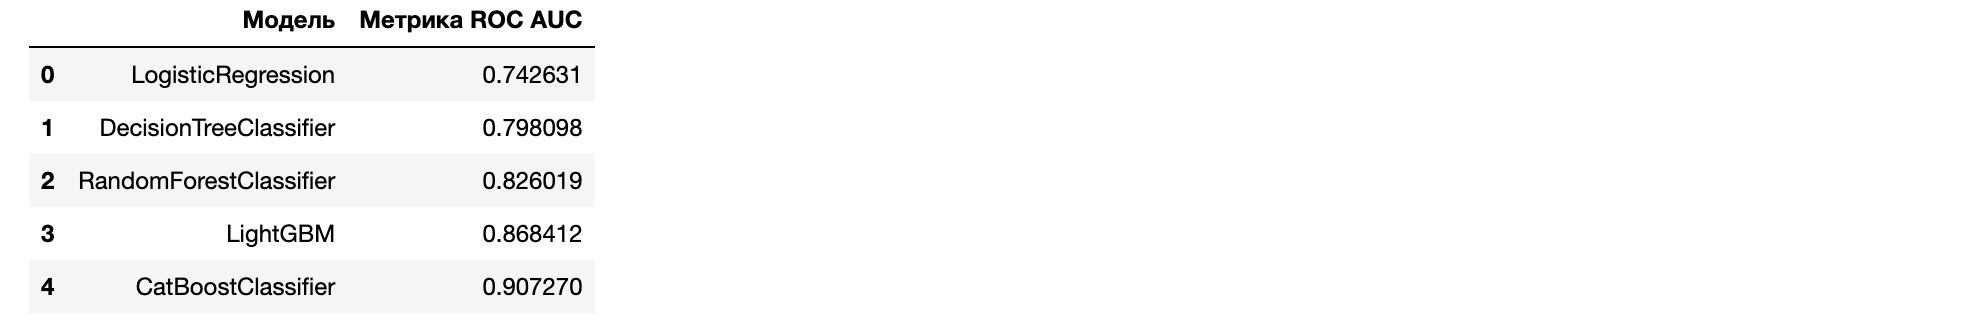

8. Требованию к метрике (ROC AUC не ниже 0.85) сответствуют только модели градиентного спуска. Самые хорошие результаты показала модель `CatBoostRegressor`с гиперпараметрами 'depth'=4, n_estimators=500, 'learning_rate'= 0.5: ROC AUC=0.9. 
9. Эта же наилучшая модель на тестовых данных показала ROC AUC=0.93, Accuracy=0.93. Модель хорошо предсказывает лояльных абонентов - которые не собираются уходить, и только в 68% правильно предсказывает абонента, который расторгнет договор.
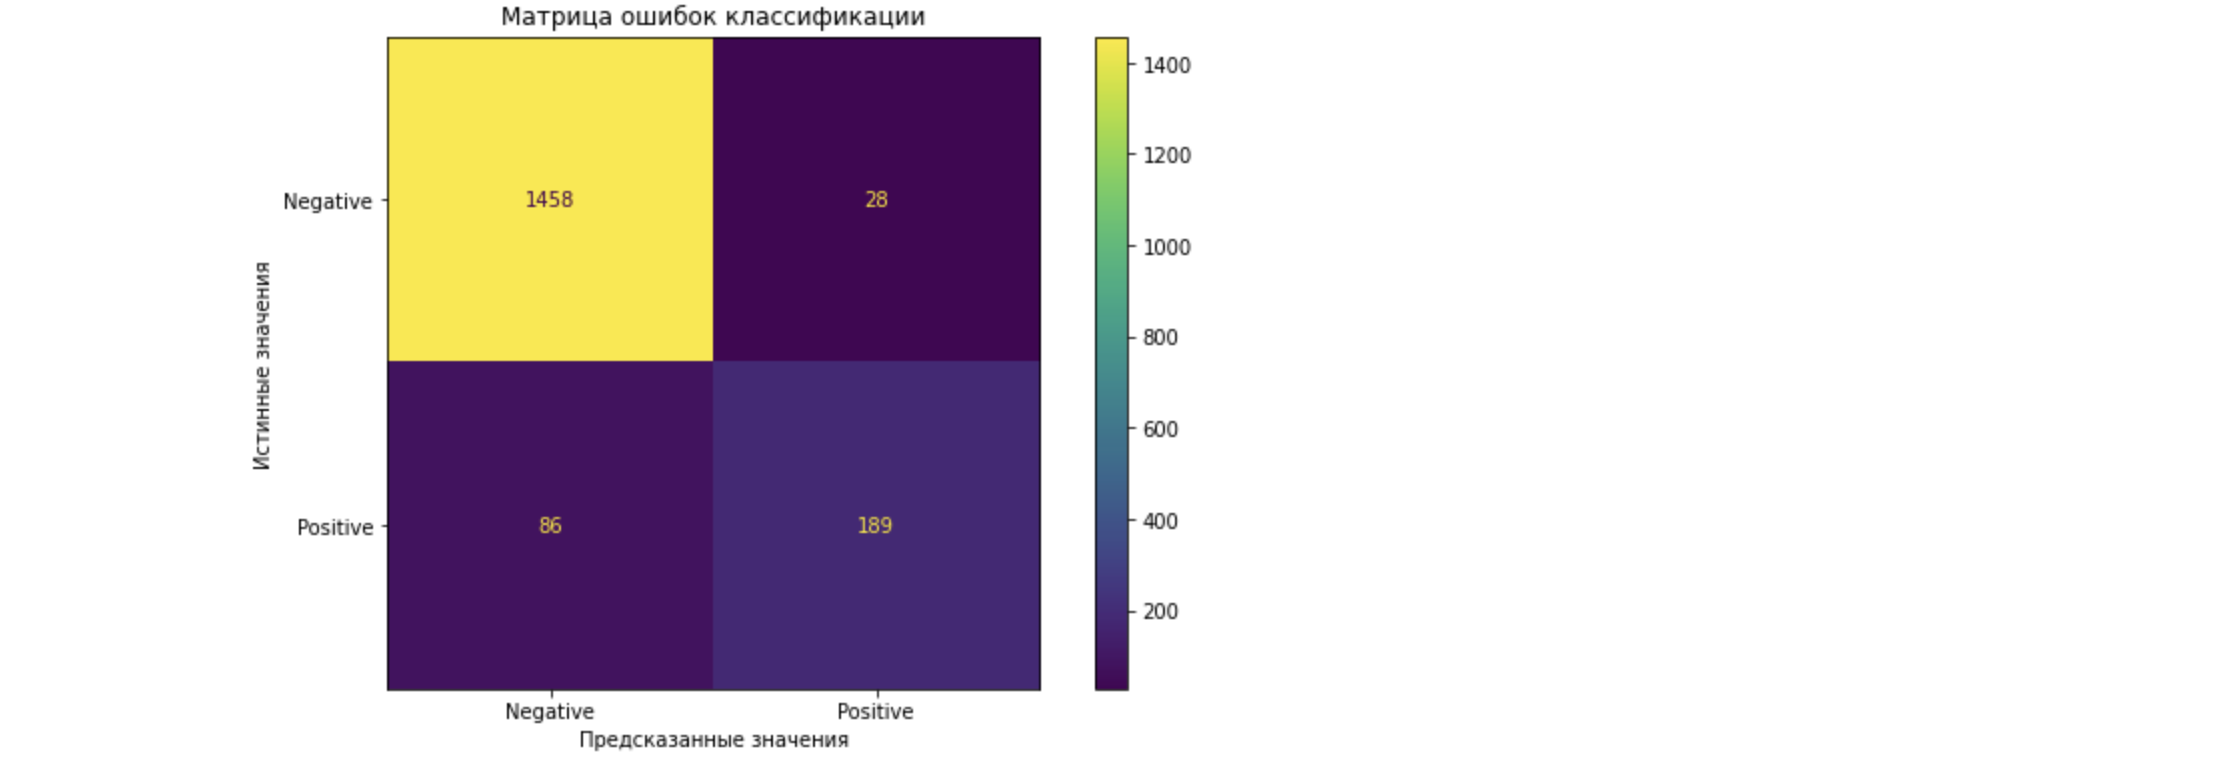

10. Самыми важными признаками для предсказания являются: "длительность договора", "расходы за месяц" и "тип оплаты: раз в год-два или ежемесячно". Самым незначительным является признак "является ли абонент пенсионером".
11. Заказчику стоит пересмотреть свои требования в части метрики: возможно бизнес-метрики в данном случае будут более информативными - например, финансовые потери от ухода клиента. Таким образом, полученная модель может оказаться не самой лучшей, так как плохо предсказывает именно уход клиента, который и приводит к финансовым потерям.
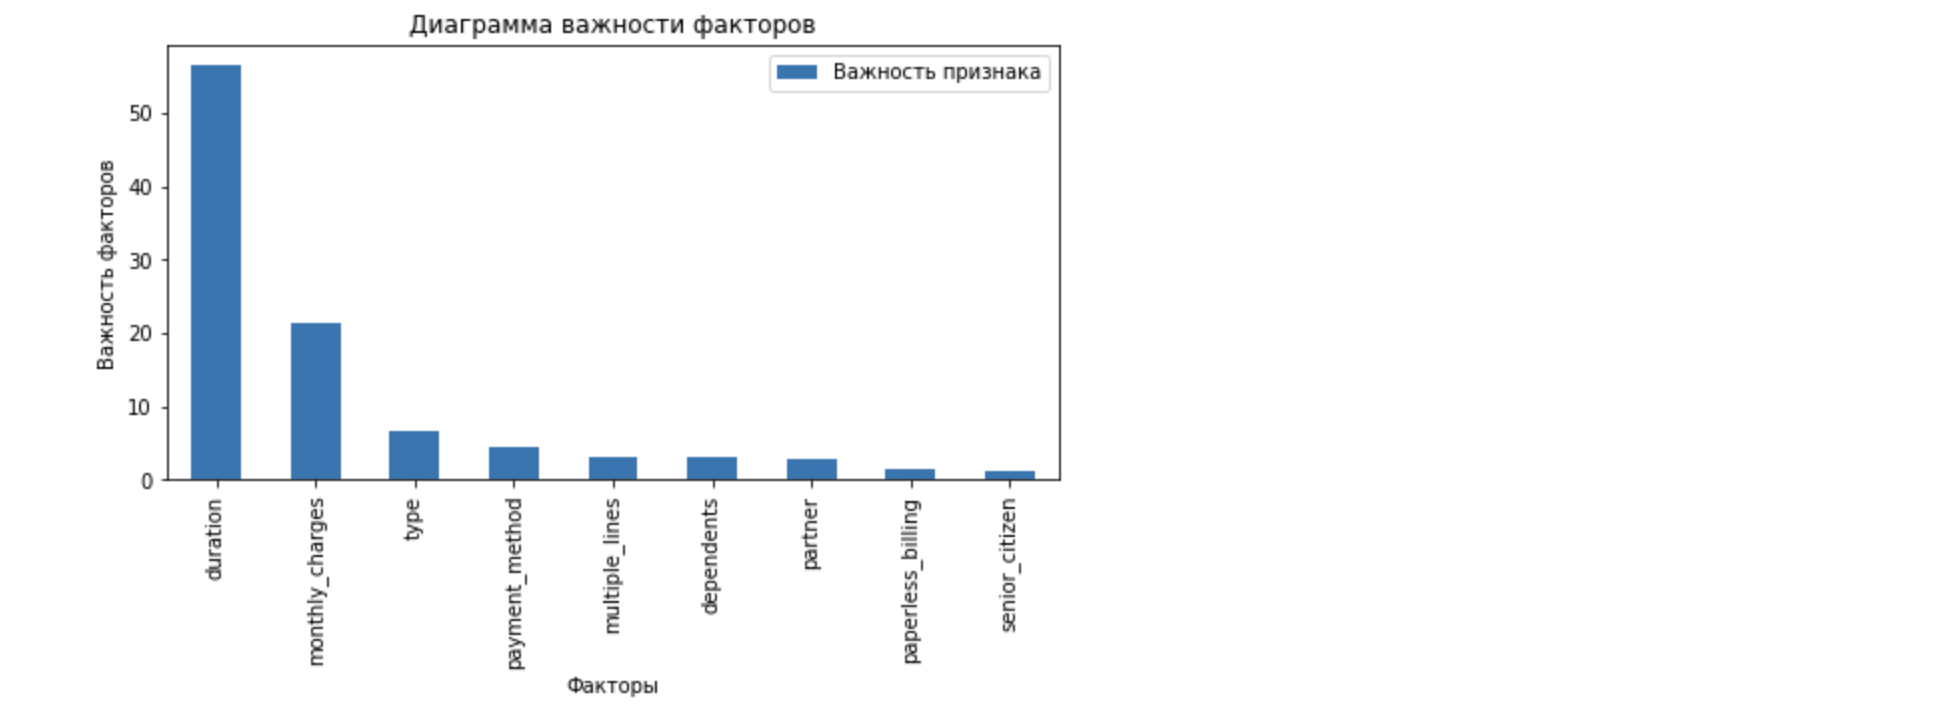

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Данные загружены и подготовлены
- [x]  Модели обучены
- [x]  Значение метрики *ROC AUC* не меньше 0.85
- [x]  Выводы написаны